### Import modules & installations & data

In [1]:
import pandas as pd, numpy as np
from matplotlib import pyplot as plt
import re, catboost, gc
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from tqdm import tqdm

import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, KFold

from catboost import CatBoostClassifier
import optuna

pd.set_option("display.max_columns", 100)

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = (
    pd.read_excel(
        'train.xlsx'
    )
    .drop(
        columns=
        ['Unnamed: 0', 'Статус брони']
    )
    .set_index('№ брони')
)

df_test = (
    pd.read_excel("test.xlsx")
    .drop(columns="Unnamed: 0")
    .set_index('№ брони')
)

df['target'] = np.where(df['Дата отмены'].isna(), 0, 1)
df.drop(columns = 'Дата отмены', inplace=True)

### Data processing & feature engineering for baseline

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26174 entries, 20230428-6634-194809261 to 20220816-6634-155783156
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Номеров             26174 non-null  int64         
 1   Стоимость           26174 non-null  float64       
 2   Внесена предоплата  26174 non-null  int64         
 3   Способ оплаты       26174 non-null  object        
 4   Дата бронирования   26174 non-null  datetime64[ns]
 5   Заезд               26174 non-null  datetime64[ns]
 6   Ночей               26174 non-null  int64         
 7   Выезд               26174 non-null  datetime64[ns]
 8   Источник            26174 non-null  object        
 9   Категория номера    26174 non-null  object        
 10  Гостей              26174 non-null  int64         
 11  Гостиница           26174 non-null  int64         
 12  target              26174 non-null  int32         
dtypes: datetime

In [4]:
num_to_month_mapper = {
    1: 'Jan', 2: 'Feb', 3: 'March',
    4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep',
    10: 'Oct', 11: 'Nov', 12: 'Dec'
}

In [5]:
def data_baseline_prepare(data):
    data_ = data.copy(deep=True)
    # Дата бронирования
    data_["booking_date_dd_mm_yy"] = pd.to_datetime(
        data_["Дата бронирования"]
    ).dt.strftime("%d-%m-%y")
    data_["booking_date_day"] = data_["Дата бронирования"].dt.day  # пусть будет
    data_["booking_date_month"] = data_["Дата бронирования"].dt.month
    data_["booking_date_month_name"] = data_["booking_date_month"].map(
        num_to_month_mapper
    )
    data_["booking_date_year"] = data_["Дата бронирования"].dt.year
    data_["booking_date_year_month"] = (
        data_["Дата бронирования"].dt.year * 100 + data_["Дата бронирования"].dt.month
    )

    # Заезд
    data_["check_in_date_dd_mm_yy"] = pd.to_datetime(data_["Заезд"]).dt.strftime(
        "%d-%m-%y"
    )
    data_["check_in_delta_booked"] = (
        data_["Заезд"] - data_["Дата бронирования"]
    ).dt.days
    data_["check_in_date_year_month"] = (
        data_["Заезд"].dt.year * 100 + data_["Заезд"].dt.month
    )
    
    # Выезд
    data_["check_out_date_dd_mm_yy"] = pd.to_datetime(data_["Выезд"]).dt.strftime(
        "%d-%m-%y"
    )
    data_["check_out_date_year_month"] = (
        data_["Выезд"].dt.year * 100 + data_["Выезд"].dt.month
    )

    print(f"in {data.shape[1]} >>> processing... >>> out {data_.shape[1]}")

    return data_

In [6]:
%%time
df_baseline = data_baseline_prepare(df)

in 13 >>> processing... >>> out 24
CPU times: total: 609 ms
Wall time: 587 ms


In [66]:
df_baseline.sample(1)

,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Заезд,Ночей,Выезд,Источник,Категория номера,Гостей,Гостиница,target,booking_date_dd_mm_yy,booking_date_day,booking_date_month,booking_date_month_name,booking_date_year,booking_date_year_month,check_in_date_dd_mm_yy,check_in_delta_booked,check_out_date_dd_mm_yy
№ брони,,,,,,,,,,,,,,,,,,,,,,
20231201-6634-237144062,1,44000.0,22000,Банк. карта: Банк Россия (банк. карта),2023-11-18 09:18:08,2023-12-01 15:00:00,2,2023-12-03 12:00:00,Официальный сайт,Апартаменты с 2 спальнями с отдельным входом,3,1,0,18-11-23,18,11,Nov,2023,202311,01-12-23,13,03-12-23


### LGBM Classifier w/ baseline

In [7]:
df_baseline.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26174 entries, 20230428-6634-194809261 to 20220816-6634-155783156
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Номеров                    26174 non-null  int64         
 1   Стоимость                  26174 non-null  float64       
 2   Внесена предоплата         26174 non-null  int64         
 3   Способ оплаты              26174 non-null  object        
 4   Дата бронирования          26174 non-null  datetime64[ns]
 5   Заезд                      26174 non-null  datetime64[ns]
 6   Ночей                      26174 non-null  int64         
 7   Выезд                      26174 non-null  datetime64[ns]
 8   Источник                   26174 non-null  object        
 9   Категория номера           26174 non-null  object        
 10  Гостей                     26174 non-null  int64         
 11  Гостиница                  26174

In [8]:
def prepare_for_lgbm(data):

    cols_to_drop = ["Дата бронирования", "Заезд", "Выезд"]
    
    data_ = data.drop(columns=cols_to_drop).copy(deep=True)
    category_cols = list(data_.select_dtypes(include="object").columns)
    data_[category_cols] = data_[category_cols].astype("category")
    
    return data_

In [9]:
df_baseline_lgbm = prepare_for_lgbm(df_baseline)
df_baseline_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26174 entries, 20230428-6634-194809261 to 20220816-6634-155783156
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Номеров                    26174 non-null  int64   
 1   Стоимость                  26174 non-null  float64 
 2   Внесена предоплата         26174 non-null  int64   
 3   Способ оплаты              26174 non-null  category
 4   Ночей                      26174 non-null  int64   
 5   Источник                   26174 non-null  category
 6   Категория номера           26174 non-null  category
 7   Гостей                     26174 non-null  int64   
 8   Гостиница                  26174 non-null  int64   
 9   target                     26174 non-null  int32   
 10  booking_date_dd_mm_yy      26174 non-null  category
 11  booking_date_day           26174 non-null  int32   
 12  booking_date_month         26174 non-null  int32   
 

In [ ]:
X = df_baseline_lgbm.drop(columns='target')
y = df_baseline_lgbm['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

model = LGBMClassifier(random_state=42, verbose=-1)
model.fit(X_train, y_train)

In [11]:
# Предсказание и оценка модели
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Оценка метрики ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC: {roc_auc:.4f}')

ROC-AUC: 0.8396


In [73]:
%%time
df_test = data_baseline_prepare(df_test)
df_test_lgbm = prepare_for_lgbm(df_test)

y_pred = model.predict(df_test_baseline_lgbm)

y_pred = pd.DataFrame(y_pred)
# y_pred.to_csv('baseline01.csv', header=None, index=False)

in 12 >>> processing... >>> out 21
CPU times: total: 453 ms
Wall time: 362 ms


---

### LGBM Classifier w/ baseline + params tuning

In [81]:
hyper_params = {
    "min_data_in_leaf": 7,
    'max_depth': 10,
    "verbose": -1, 
    "learning_rate" : 0.01,
    "n_estimators": 250,
    "num_leaves": 100,
}

model = LGBMClassifier(**hyper_params)
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]

# Оценка метрики ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC: {roc_auc:.4f}')

ROC-AUC: 0.8507


In [67]:
def show_importances(model):
    gain_importance = model.feature_importances_
    feature_names = X_train.columns

    df_importance = (
        pd.DataFrame({'Feature': feature_names, 'Gain (Split)': gain_importance})
        .sort_values(by='Gain (Split)', ascending=False)
    )
    display(df_importance)
    top_features = df_importance['Feature'].head(20).values

    print('Model params:')
    model_params = model.get_params(True)
    [print(x, ':', model_params[x]) for x in model_params]

    lgb.plot_importance(
        model, importance_type = "gain", figsize=(7,6), 
        max_num_features = 20, title="LightGBM Feature Importance (Gain)"
    )

    plt.show()
    print('------------------------------------------')
    
# show_importances(model)

#### Adding calendar

In [86]:
from workalendar.europe import Russia
calendar_rus = Russia()

In [130]:
def calendar_features(data):
    data_ = data.copy(deep=True)
    # праздник / рабочий день (заезд)
    tqdm.pandas()
    data_['check_in_is_holiday'] = (
        data_['Заезд'].progress_apply(lambda x: 0 if calendar_rus.is_working_day(x) else 1)
    )
    # праздник / рабочий день (бронь)
    data_['booking_date_is_holiday'] = (
        data_['Дата бронирования'].progress_apply(lambda x: 0 if calendar_rus.is_working_day(x) else 1)
    )
    # праздник / рабочий день (бронь)
    data_['check_out_is_holiday'] = (
        data_['Выезд'].progress_apply(lambda x: 0 if calendar_rus.is_working_day(x) else 1)
    )
    # день недели (бронь + заезд + выезд)
    data_['check_in_weekday'] = data_['Заезд'].dt.weekday
    data_['booking_date_weekday'] = data_['Дата бронирования'].dt.weekday
    data_['check_out_weekday'] = data_['Выезд'].dt.weekday
    
    print(f"in {data.shape[1]} >>> processing... >>> out {data_.shape[1]}")

    return data_

In [131]:
%%time 
df_baseline_w_calendar = calendar_features(df_baseline)

100%|██████████| 26174/26174 [00:00<00:00, 233900.60it/s]

in 22 >>> processing... >>> out 28
CPU times: total: 344 ms
Wall time: 367 ms


In [132]:
df_baseline_w_calendar_lgbm = prepare_for_lgbm(df_baseline_w_calendar)
df_baseline_w_calendar_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26174 entries, 20230428-6634-194809261 to 20220816-6634-155783156
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Номеров                  26174 non-null  int64   
 1   Стоимость                26174 non-null  float64 
 2   Внесена предоплата       26174 non-null  int64   
 3   Способ оплаты            26174 non-null  category
 4   Ночей                    26174 non-null  int64   
 5   Источник                 26174 non-null  category
 6   Категория номера         26174 non-null  category
 7   Гостей                   26174 non-null  int64   
 8   Гостиница                26174 non-null  int64   
 9   target                   26174 non-null  int32   
 10  booking_date_dd_mm_yy    26174 non-null  category
 11  booking_date_day         26174 non-null  int32   
 12  booking_date_month       26174 non-null  int32   
 13  booking_date_month_name  2

In [152]:
hyper_params2 = {
    "objective": 'binary',
    "min_data_in_leaf": 7,
    'max_depth': 10,
    "verbose": -1,
    "subsample": 0.9,
    "learning_rate" : 0.01,
    "n_estimators": 200,
    "num_leaves": 100,
}

X = df_baseline_w_calendar_lgbm.drop(columns='target')
y = df_baseline_w_calendar_lgbm['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

lgb_base_k1 = LGBMClassifier(**hyper_params2)
lgb_base_k1.fit(X_train, y_train)

y_pred_proba = lgb_base_k1.predict_proba(X_test)[:, 1]

# Оценка метрики ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC: {roc_auc:.4f}')

ROC-AUC: 0.8517


In [154]:
%%time
df_test = (
    pd.read_excel("test.xlsx")
    .drop(columns="Unnamed: 0")
    .set_index('№ брони')
)
df_test = data_baseline_prepare(df_test)
df_test = calendar_features(df_test)
df_test_lgbm = prepare_for_lgbm(df_test)

y_pred = lgb_base_k1.predict(df_test_lgbm)

y_pred = pd.DataFrame(y_pred)
y_pred.to_csv('baseline02.csv', header=None, index=False)

in 12 >>> processing... >>> out 21


100%|██████████| 11218/11218 [00:00<00:00, 233839.11it/s]

in 21 >>> processing... >>> out 27


CPU times: total: 3.03 s
Wall time: 2.82 s


,Feature,Gain (Split)
16,check_in_delta_booked,3399
1,Стоимость,3130
2,Внесена предоплата,2331
10,booking_date_day,1640
9,booking_date_dd_mm_yy,957
14,booking_date_year_month,922
22,booking_date_weekday,839
4,Ночей,695
8,Гостиница,689
17,check_out_date_dd_mm_yy,671


Model params:
boosting_type : gbdt
class_weight : None
colsample_bytree : 1.0
importance_type : split
learning_rate : 0.01
max_depth : 10
min_child_samples : 20
min_child_weight : 0.001
min_split_gain : 0.0
n_estimators : 200
n_jobs : None
num_leaves : 100
objective : binary
random_state : None
reg_alpha : 0.0
reg_lambda : 0.0
subsample : 0.9
subsample_for_bin : 200000
subsample_freq : 0
min_data_in_leaf : 7
verbose : -1


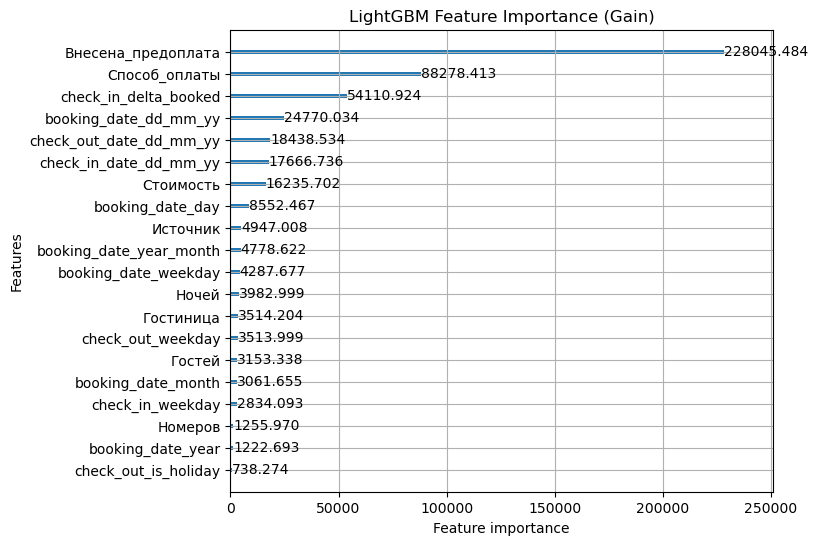

------------------------------------------


In [153]:
show_importances(lgb_base_k1)

### Further experiements setup

In [170]:
%%time
df_baseline_2 = data_baseline_prepare(df)

df_baseline_w_calendar_2 = calendar_features(df_baseline_2)

df_baseline_w_calendar_2_lgbm = prepare_for_lgbm(df_baseline_w_calendar_2)

df_baseline_w_calendar_2_lgbm["Источник_agg"] = (
    df_baseline_w_calendar_2_lgbm["Источник"]
    .apply(
        lambda x: x
        if x
        in ["Официальный сайт", "Программа лояльности", "Бронирование из экстранета"]
        else x.split()[0]
    )
    .astype("category")
)
df_baseline_w_calendar_2_lgbm["Категория_номера_agg"] = (
    df["Категория номера"]
    .apply(lambda x: pd.Series(x.split("\n")).mode()[0])
    .astype("category")
)
X = df_baseline_w_calendar_2_lgbm.drop(columns=["target"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

lgb_base_k2 = LGBMClassifier(**hyper_params2)
lgb_base_k2.fit(X_train, y_train)

y_pred_proba = lgb_base_k2.predict_proba(X_test)[:, 1]

# Оценка метрики ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

in 13 >>> processing... >>> out 24


100%|██████████| 26174/26174 [00:00<00:00, 276550.54it/s]


in 24 >>> processing... >>> out 30
ROC-AUC: 0.8569
CPU times: total: 9.8 s
Wall time: 6.65 s


,Feature,Gain (Split)
1,Стоимость,3294
16,check_in_delta_booked,3232
2,Внесена предоплата,2288
10,booking_date_day,1402
9,booking_date_dd_mm_yy,1069
15,check_in_date_dd_mm_yy,769
18,check_out_date_dd_mm_yy,743
8,Гостиница,718
24,booking_date_weekday,717
25,check_out_weekday,701


Model params:
boosting_type : gbdt
class_weight : None
colsample_bytree : 1.0
importance_type : split
learning_rate : 0.01
max_depth : 10
min_child_samples : 20
min_child_weight : 0.001
min_split_gain : 0.0
n_estimators : 200
n_jobs : None
num_leaves : 100
objective : binary
random_state : None
reg_alpha : 0.0
reg_lambda : 0.0
subsample : 0.9
subsample_for_bin : 200000
subsample_freq : 0
min_data_in_leaf : 7
verbose : -1


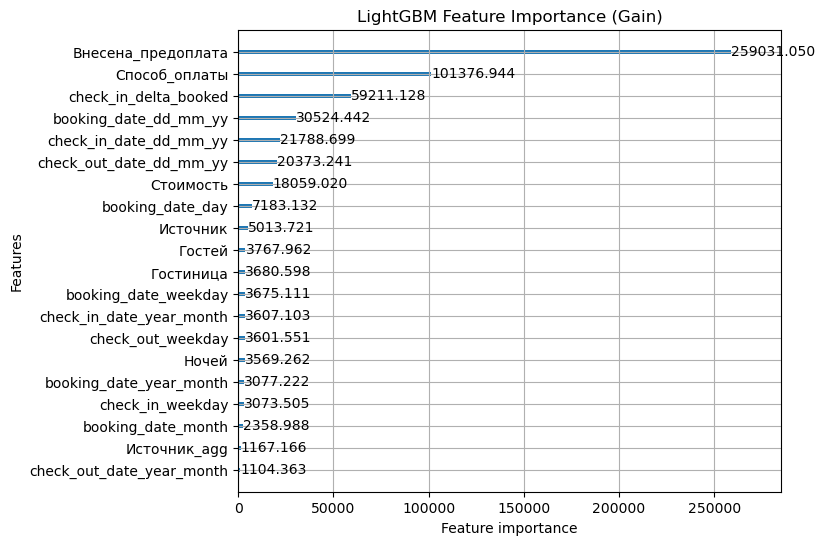

------------------------------------------


In [171]:
# so - so
show_importances(lgb_base_k2)

In [186]:
%load_ext autoreload
%autoreload 2
from feature_generation_funcs import (
    data_baseline_prepare_, price_features_, calendar_features_)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [181]:
# %#%time
df_ne_baseline = data_baseline_prepare_(df)

df_ne_baseline_w_calendar_2 = calendar_features_(df_ne_baseline)

df_ne_baseline_w_calendar_price = price_features_(df_ne_baseline_w_calendar_2)

df_ne_baseline_w_calendar_price_lgbm = prepare_for_lgbm(df_ne_baseline_w_calendar_price)


df_ne_baseline_w_calendar_price_lgbm["Источник_agg"] = (
    df_ne_baseline_w_calendar_price_lgbm["Источник"]
    .apply(
        lambda x: x
        if x
        in ["Официальный сайт", "Программа лояльности", "Бронирование из экстранета"]
        else x.split()[0]
    )
    .astype("category")
)
df_ne_baseline_w_calendar_price_lgbm["Категория_номера_agg"] = (
    df["Категория номера"]
    .apply(lambda x: pd.Series(x.split("\n")).mode()[0])
    .astype("category")
)
X = df_ne_baseline_w_calendar_price_lgbm.drop(columns=["target"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

lgbm_destroy = LGBMClassifier(**hyper_params2)
lgbm_destroy.fit(X_train, y_train)

y_pred_proba = lgbm_destroy.predict_proba(X_test)[:, 1]

# Оценка метрики ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

in 13 >>> processing... >>> out 24


100%|██████████| 26174/26174 [00:00<00:00, 264748.60it/s]


in 24 >>> processing... >>> out 32
ROC-AUC: 0.8583
CPU times: total: 9.45 s
Wall time: 5.91 s


In [220]:
hyper_params2 = {
    "objective": 'binary',
    "min_data_in_leaf": 7,
    'max_depth': 10,
    "verbose": -1,
#     "subsample": 0.9,
    "learning_rate" : 0.01,
    "n_estimators": 200,
    "num_leaves": 100,
}

lgbm_destroy = LGBMClassifier(**hyper_params2)
lgbm_destroy.fit(X_train, y_train)

y_pred_proba = lgbm_destroy.predict_proba(X_test)[:, 1]

# Оценка метрики ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

ROC-AUC: 0.8273


,Feature,Gain (Split)
16,check_in_delta_booked,2495
1,Стоимость,1910
2,Внесена предоплата,1449
28,Цена_за_ночь,1129
9,booking_date_dd_mm_yy,1085
31,avg_price_weekday_month,973
10,booking_date_day,896
29,avg_price_weekly,857
32,median_price_weekday_month,845
15,check_in_date_dd_mm_yy,763


Model params:
boosting_type : gbdt
class_weight : None
colsample_bytree : 1.0
importance_type : split
learning_rate : 0.01
max_depth : 10
min_child_samples : 20
min_child_weight : 0.001
min_split_gain : 0.0
n_estimators : 200
n_jobs : None
num_leaves : 100
objective : binary
random_state : None
reg_alpha : 0.0
reg_lambda : 0.0
subsample : 0.9
subsample_for_bin : 200000
subsample_freq : 0
min_data_in_leaf : 7
verbose : -1


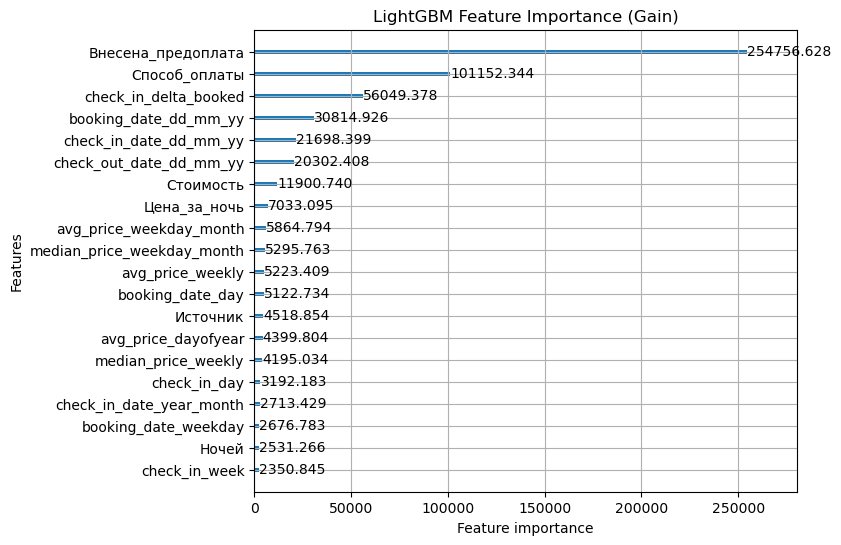

------------------------------------------


In [183]:
show_importances(lgbm_destroy)

In [224]:
%%time
df_ne_baseline = data_baseline_prepare_(df)

df_ne_baseline_w_calendar_2 = calendar_features_(df_ne_baseline)

df_ne_baseline_w_calendar_price = price_features_(df_ne_baseline_w_calendar_2)

df_ne_baseline_w_calendar_price_lgbm = prepare_for_lgbm(df_ne_baseline_w_calendar_price)

X = df_ne_baseline_w_calendar_price_lgbm.drop(columns=["target"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=64, stratify=y
)

lgbm_destroy = LGBMClassifier(**hyper_params2)
lgbm_destroy.fit(X_train, y_train)

y_pred_proba = lgbm_destroy.predict_proba(X_test)[:, 1]

# Оценка метрики ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

in 13 >>> processing... >>> out 26


100%|██████████| 26174/26174 [00:00<00:00, 268602.11it/s]


in 26 >>> processing... >>> out 34
ROC-AUC: 0.8273
CPU times: total: 9.09 s
Wall time: 5.97 s


,Feature,Gain (Split)
16,check_in_delta_booked,2619
1,Стоимость,1643
2,Внесена предоплата,1281
30,Цена_за_ночь,1114
10,booking_date_day,1074
9,booking_date_dd_mm_yy,1055
31,avg_price_weekly,896
33,avg_price_weekday_month,872
35,avg_price_dayofyear,861
34,median_price_weekday_month,810


Model params:
boosting_type : gbdt
class_weight : None
colsample_bytree : 1.0
importance_type : split
learning_rate : 0.01
max_depth : 10
min_child_samples : 20
min_child_weight : 0.001
min_split_gain : 0.0
n_estimators : 200
n_jobs : None
num_leaves : 100
objective : binary
random_state : None
reg_alpha : 0.0
reg_lambda : 0.0
subsample : 1.0
subsample_for_bin : 200000
subsample_freq : 0
min_data_in_leaf : 7
verbose : -1


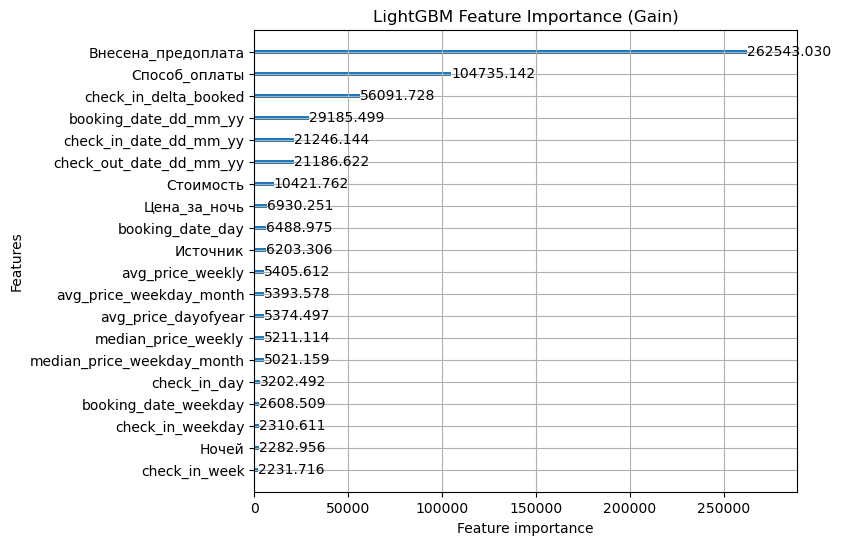

------------------------------------------


In [225]:
show_importances(lgbm_destroy)

In [190]:
%%time

%load_ext autoreload
%autoreload 2
from feature_generation_funcs import (
    data_baseline_prepare_, price_features_, calendar_features_)
df_test = (
    pd.read_excel("test.xlsx")
    .drop(columns="Unnamed: 0")
    .set_index('№ брони')
)
df_test = data_baseline_prepare_(df_test)
df_test = calendar_features_(df_test)
df_test = price_features_(df_test)
df_test = prepare_for_lgbm(df_test)

y_pred = lgbm_destroy.predict(df_test)

y_pred = pd.DataFrame(y_pred)
y_pred.to_csv('baseline03.csv', header=None, index=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
in 12 >>> processing... >>> out 25


100%|██████████| 11218/11218 [00:00<00:00, 225742.34it/s]

in 25 >>> processing... >>> out 33


CPU times: total: 4.52 s
Wall time: 4.38 s


In [209]:
gain_importance = lgbm_destroy.feature_importances_
feature_names = X_train.columns

df_importance = (
    pd.DataFrame({'Feature': feature_names, 'Gain (Split)': gain_importance})
    .sort_values(by='Gain (Split)', ascending=False)
)
top_features = df_importance['Feature'].head(28).values

In [210]:
top_features

array(['check_in_delta_booked', 'Стоимость', 'Внесена предоплата',
       'booking_date_dd_mm_yy', 'Цена_за_ночь', 'avg_price_weekday_month',
       'booking_date_day', 'avg_price_weekly',
       'median_price_weekday_month', 'check_in_date_dd_mm_yy',
       'check_out_date_dd_mm_yy', 'median_price_weekly',
       'avg_price_dayofyear', 'check_in_day', 'booking_date_weekday',
       'check_out_weekday', 'check_in_week', 'Ночей', 'Гостей',
       'check_in_weekday', 'booking_date_year_month', 'Способ оплаты',
       'Гостиница', 'check_in_date_year_month', 'Источник',
       'booking_date_month', 'is_beneficial_3', 'booking_date_is_holiday'],
      dtype=object)

In [211]:
lgbm_destroy_mini = LGBMClassifier(**hyper_params2)
lgbm_destroy_mini.fit(X_train[top_features], y_train),

y_pred_proba = lgbm_destroy_mini.predict_proba(X_test[top_features])[:, 1]
# Оценка метрики ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

ROC-AUC: 0.8588


In [ ]:
y_pred = lgbm_destroy_mini.predict(df_test[top_features])

In [228]:
%%time

%load_ext autoreload
%autoreload 2
from feature_generation_funcs import (
    data_baseline_prepare_, price_features_, calendar_features_)

df_ne_baseline = data_baseline_prepare_(df)

df_ne_baseline_w_calendar_2 = calendar_features_(df_ne_baseline)

df_ne_baseline_w_calendar_price = price_features_(df_ne_baseline_w_calendar_2)

df_ne_baseline_w_calendar_price_lgbm = prepare_for_lgbm(df_ne_baseline_w_calendar_price)

X = df_ne_baseline_w_calendar_price_lgbm.drop(columns=["target"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=64, stratify=y
)

lgbm_destroy = LGBMClassifier(**hyper_params2)
lgbm_destroy.fit(X_train, y_train)

y_pred_proba = lgbm_destroy.predict_proba(X_test)[:, 1]

# Оценка метрики ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
in 13 >>> processing... >>> out 27


100%|██████████| 26174/26174 [00:00<00:00, 240549.44it/s]


in 27 >>> processing... >>> out 35
ROC-AUC: 0.8279
CPU times: total: 9.22 s
Wall time: 5.87 s


,Feature,Gain (Split)
16,check_in_delta_booked,2683
1,Стоимость,1623
2,Внесена предоплата,1318
10,booking_date_day,1100
31,Цена_за_ночь,1098
9,booking_date_dd_mm_yy,1035
32,avg_price_weekly,859
36,avg_price_dayofyear,821
35,median_price_weekday_month,817
34,avg_price_weekday_month,797


Model params:
boosting_type : gbdt
class_weight : None
colsample_bytree : 1.0
importance_type : split
learning_rate : 0.01
max_depth : 10
min_child_samples : 20
min_child_weight : 0.001
min_split_gain : 0.0
n_estimators : 200
n_jobs : None
num_leaves : 100
objective : binary
random_state : None
reg_alpha : 0.0
reg_lambda : 0.0
subsample : 1.0
subsample_for_bin : 200000
subsample_freq : 0
min_data_in_leaf : 7
verbose : -1


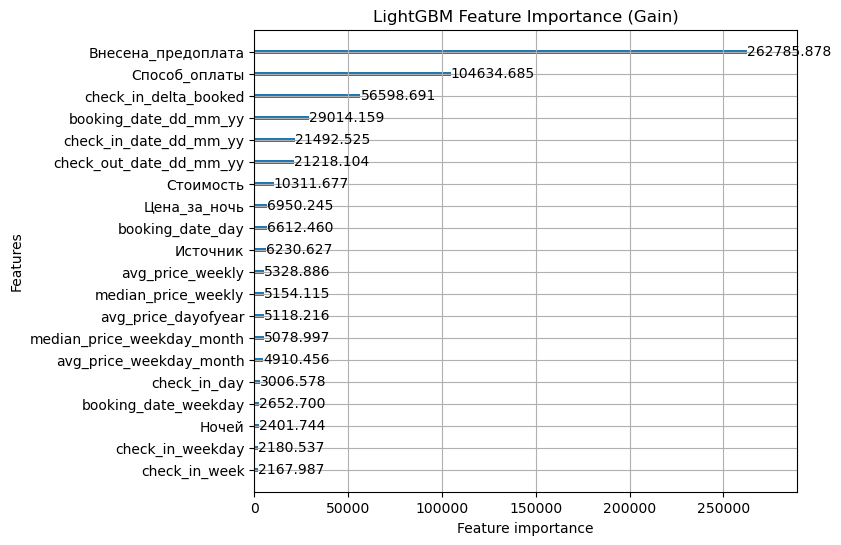

------------------------------------------


In [229]:
show_importances(lgbm_destroy)

### Catboost 

In [231]:
%%time

%load_ext autoreload
%autoreload 2
from feature_generation_funcs import (
    data_baseline_prepare_, price_features_, calendar_features_)

df_ne_baseline = data_baseline_prepare_(df)

df_ne_baseline_w_calendar_2 = calendar_features_(df_ne_baseline)

df_ne_baseline_w_calendar_price = price_features_(df_ne_baseline_w_calendar_2)

df_ne_baseline_w_calendar_price_lgbm = prepare_for_lgbm(df_ne_baseline_w_calendar_price)

X = df_ne_baseline_w_calendar_price_lgbm.drop(columns=["target"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=64, stratify=y
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
in 13 >>> processing... >>> out 27


100%|██████████| 26174/26174 [00:00<00:00, 166102.63it/s]


in 27 >>> processing... >>> out 35
CPU times: total: 5.89 s
Wall time: 6 s


In [ ]:
# Указание категориальных признаков
categorical_features_indices = X_train.select_dtypes(
    include=["object", "category"]
).columns.tolist()


# Определение функции для оптимизации
def objective(trial):
    # Определение пространства гиперпараметров
    param = {
        "iterations": trial.suggest_int("iterations", 20, 100),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1, 10),
        "random_seed": 42,
        "cat_features": categorical_features_indices,
        "verbose": 0,  # Отключаем вывод
    }

    # Создание и обучение модели CatBoostClassifier
    model = CatBoostClassifier(**param)

    # Обучение модели
    model.fit(
        X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0
    )

    # Получение вероятностей принадлежности к классу 1 на тестовой выборке
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Оценка качества модели с использованием ROC AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return roc_auc


# Запуск оптимизации
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Вывод лучших параметров
print("Best trial:")
trial = study.best_trial
print(f"  Value (ROC AUC): {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

In [237]:
study.best_params

{'iterations': 711,
 'depth': 6,
 'learning_rate': 0.04684882487914798,
 'l2_leaf_reg': 3.4081458567942513}

In [244]:
categorical_features_indices = X_train.select_dtypes(
    include=["object", "category"]
).columns.tolist()

param = {
    "iterations": 400,
    "depth": 8,
    "learning_rate": 0.002,
    "l2_leaf_reg": 3.4,
    "random_seed": 42,
    "cat_features": categorical_features_indices,
    "verbose": 0,  # Отключаем вывод
}

model = CatBoostClassifier(**param)

# Обучение модели
model.fit(
    X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0
)

# Получение вероятностей принадлежности к классу 1 на тестовой выборке
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [245]:
model_optuna = CatBoostClassifier(**param)
model_optuna.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0)

In [248]:
y_pred_proba = model_optuna.predict_proba(X_test)[:, 1]

# Оценка метрики ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

ROC-AUC: 0.8308


#### NN outputs

In [15]:
# выходы нейронки
scores_train4 = pd.read_csv('nn_04_train.csv', header=None)

In [16]:
scores_train

,0
0,0.995597
1,0.050380
2,0.178422
3,0.018333
4,0.019311
...,...
26169,0.106104
26170,0.023654
26171,0.124293
26172,0.654079


In [17]:
hyper_params2 = {
    "objective": 'binary',
    "min_data_in_leaf": 7,
    'max_depth': 9,
    "verbose": -1,
    "subsample": 0.8,
    "learning_rate" : 0.04,
    "n_estimators": 240,
    "num_leaves": 100,
}

In [18]:
df_ne_baseline = data_baseline_prepare_(df)

df_ne_baseline_w_calendar_2 = calendar_features_(df_ne_baseline)

df_ne_baseline_w_calendar_2 = sin_cos_coder(df_ne_baseline_w_calendar_2)

df_ne_baseline_w_calendar_price = price_features_(df_ne_baseline_w_calendar_2)

df_ne_baseline_w_calendar_price_lgbm = prepare_for_lgbm(df_ne_baseline_w_calendar_price)

X = df_ne_baseline_w_calendar_price_lgbm.drop(columns=["target"])
X.loc[:, 'neuro_scores'] = scores_train.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

in 13 >>> processing... >>> out 27


100%|██████████| 26174/26174 [00:00<00:00, 223037.91it/s]


in 27 >>> processing... >>> out 35


### 0.8669

In [19]:
%%time

%load_ext autoreload
%autoreload 2
from feature_generation_funcs import (
    data_baseline_prepare_, price_features_, calendar_features_, sin_cos_coder)

df_ne_baseline = data_baseline_prepare_(df)

df_ne_baseline_w_calendar_2 = calendar_features_(df_ne_baseline)

df_ne_baseline_w_calendar_2 = sin_cos_coder(df_ne_baseline_w_calendar_2)

df_ne_baseline_w_calendar_price = price_features_(df_ne_baseline_w_calendar_2)

df_ne_baseline_w_calendar_price_lgbm = prepare_for_lgbm(df_ne_baseline_w_calendar_price)

X = df_ne_baseline_w_calendar_price_lgbm.drop(columns=["target"])
X.loc[:, 'neuro_scores'] = scores_train.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

lgbm_destroyX = LGBMClassifier(**hyper_params2)
lgbm_destroyX.fit(X_train, y_train)

y_pred_proba = lgbm_destroyX.predict_proba(X_test)[:, 1]

# Оценка метрики ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
in 13 >>> processing... >>> out 27


100%|██████████| 26174/26174 [00:00<00:00, 228209.84it/s]


in 27 >>> processing... >>> out 35
ROC-AUC: 0.8669
CPU times: total: 10.7 s
Wall time: 6.5 s


### Optuna setup + 0.8738

In [ ]:
def objective(trial):
    
    param_grid = {
        "objective": trial.suggest_categorical("objective", ["binary", "poisson"]),
        'max_depth': trial.suggest_int("max_depth", 3, 12),
        'subsample': trial.suggest_float("subsample", 0.4, 1, step = 0.2),
        "verbose": -1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.1, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 400, 50),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 20),
        "reg_lambda":  trial.suggest_float("reg_lambda", 0, 1.2, step = 0.3)}
    model = LGBMClassifier(**param_grid)
    
    kf = KFold(n_splits=4, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kf, scoring='roc_auc')
    
    return roc_auc

# Запуск оптимизации
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Вывод лучших параметров
print("Best trial:")
trial = study.best_trial
print(f"  Value (ROC AUC): {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

In [20]:
%%time

%load_ext autoreload
%autoreload 2
from feature_generation_funcs import (
    data_baseline_prepare_, price_features_, calendar_features_, sin_cos_coder)

hyper_params4 = {
    "objective": 'binary',
    "min_data_in_leaf": 12,
    'max_depth': 8,
    "verbose": -1,
    "subsample": 0.8,
    "learning_rate" : 0.004,
    "n_estimators": 180,
    "num_leaves": 100,
    "reg_lambda": 1.2
}


df_ne_baseline = data_baseline_prepare_(df)

df_ne_baseline_w_calendar_2 = calendar_features_(df_ne_baseline)

df_ne_baseline_w_calendar_2 = sin_cos_coder(df_ne_baseline_w_calendar_2)

df_ne_baseline_w_calendar_price = price_features_(df_ne_baseline_w_calendar_2)

df_ne_baseline_w_calendar_price_lgbm = prepare_for_lgbm(df_ne_baseline_w_calendar_price)

X = df_ne_baseline_w_calendar_price_lgbm.drop(columns=["target"])
X.loc[:, 'neuro_scores'] = scores_train.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

lgbm_destroyX = LGBMClassifier(**hyper_params4)
lgbm_destroyX.fit(X_train, y_train)

y_pred_proba = lgbm_destroyX.predict_proba(X_test)[:, 1]

# Оценка метрики ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
in 13 >>> processing... >>> out 27


100%|██████████| 26174/26174 [00:00<00:00, 242226.63it/s]


in 27 >>> processing... >>> out 35
ROC-AUC: 0.8738
CPU times: total: 8.45 s
Wall time: 5.74 s


In [295]:
y_pred = lgbm_destroyX.predict_proba(df_test)[:, 1]

y_pred = pd.DataFrame(y_pred)
y_pred.to_csv('baseline07.csv', header=None, index=False)

In [298]:
y_pred_proba

array([0.10077279, 0.16345112, 0.25443988, ..., 0.10077279, 0.60812266,
       0.60812266])

In [299]:
neuro = lgbm_destroyX.predict_proba(X)[:, 1]

neuro = pd.DataFrame(neuro)
neuro.to_csv('baseline07_neuro_scores.csv', header=None, index=False)

In [ ]:
%load_ext autoreload
%autoreload 2
from feature_generation_funcs import (
    data_baseline_prepare_, price_features_, calendar_features_)
df_test = (
    pd.read_excel("test.xlsx")
    .drop(columns="Unnamed: 0")
    .set_index('№ брони')
)
df_test = data_baseline_prepare_(df_test)
df_test = calendar_features_(df_test)
df_test = sin_cos_coder(df_test)
df_test = price_features_(df_test)
df_test.loc[:, 'neuro_scores'] = scores_test.values
df_test = prepare_for_lgbm(df_test)
y_pred = lgbm_destroyX.predict_proba(df_test)[:, 1]

y_pred = pd.DataFrame(y_pred)
y_pred.to_csv('baseline05.csv', header=None, index=False)

In [262]:
scores_train

,0
0,0.995597
1,0.050380
2,0.178422
3,0.018333
4,0.019311
...,...
26169,0.106104
26170,0.023654
26171,0.124293
26172,0.654079


In [263]:
X.loc[:, 'neuro_scores'] = scores_train.values

In [269]:
scores_test = pd.read_csv('nn_04.csv', header=None)

In [272]:
%load_ext autoreload
%autoreload 2

scores_test = pd.read_csv('nn_04.csv', header=None)
from feature_generation_funcs import (
    data_baseline_prepare_, price_features_, calendar_features_)
df_test = (
    pd.read_excel("test.xlsx")
    .drop(columns="Unnamed: 0")
    .set_index('№ брони')
)
df_test = data_baseline_prepare_(df_test)
df_test = calendar_features_(df_test)
df_test = sin_cos_coder(df_test)
df_test = price_features_(df_test)
df_test.loc[:, 'neuro_scores'] = scores_test.values
df_test = prepare_for_lgbm(df_test)
y_pred = lgbm_destroyX.predict_proba(df_test)[:, 1]

y_pred = pd.DataFrame(y_pred)
y_pred.to_csv('baseline05.csv', header=None, index=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
in 12 >>> processing... >>> out 26


100%|██████████| 11218/11218 [00:00<00:00, 208164.82it/s]

in 26 >>> processing... >>> out 34


In [273]:
y_pred = lgbm_destroyX.predict_proba(df_test)[:, 1]

y_pred = pd.DataFrame(y_pred)
y_pred.to_csv('baseline05.csv', header=None, index=False)

,Feature,Gain (Split)
48,neuro_scores,2888
1,Стоимость,1413
16,check_in_delta_booked,1410
2,Внесена предоплата,1000
9,booking_date_dd_mm_yy,939
39,Цена_за_ночь,928
42,avg_price_weekday_month,733
31,booking_date_day_sin,729
44,avg_price_dayofyear,691
15,check_in_date_dd_mm_yy,689


Model params:
boosting_type : gbdt
class_weight : None
colsample_bytree : 1.0
importance_type : split
learning_rate : 0.05
max_depth : 10
min_child_samples : 20
min_child_weight : 0.001
min_split_gain : 0.0
n_estimators : 200
n_jobs : None
num_leaves : 100
objective : binary
random_state : None
reg_alpha : 0.0
reg_lambda : 0.0
subsample : 1.0
subsample_for_bin : 200000
subsample_freq : 0
min_data_in_leaf : 7
verbose : -1


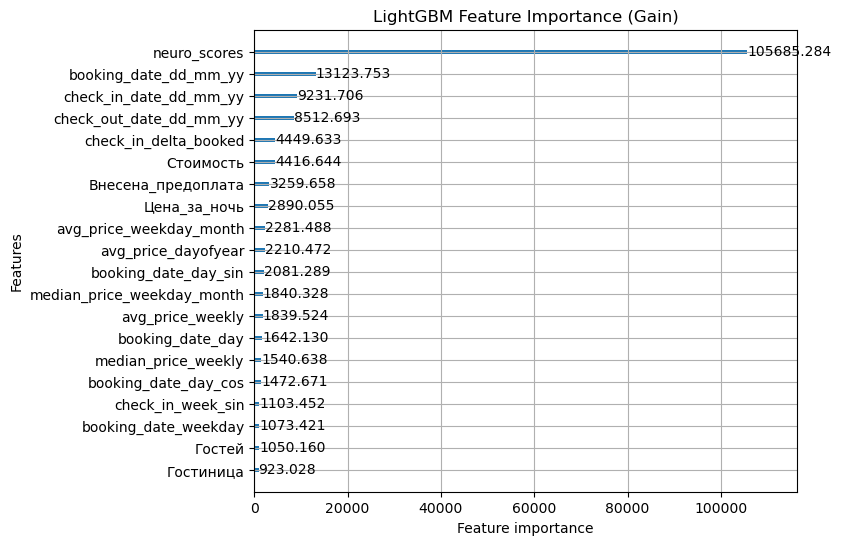

------------------------------------------


In [274]:
show_importances(lgbm_destroyX)

### API Visual Crossing

In [311]:
# Координаты Роза Хутор
latitude = 43.6715
longitude = 40.2979

In [165]:
import requests
import sys
import json

response = requests.request(
    "GET",
    "https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/43.6715%2C40.2979/2022-01-01/2023-12-31?unitGroup=us&include=days%2Cevents%2Calerts&key=HS46ZNCNSNEHZZ5KB7MEC3L2X&contentType=json",
)
if response.status_code != 200:
    print("Unexpected Status code: ", response.status_code)
    sys.exit()


# Parse the results as JSON
jsonData = response.json()

In [335]:
import json
with open('weather_roza_hutor.json', 'w') as f:
    json.dump(jsonData, f)

In [2]:
# jsonData['days']

In [337]:
df_weather = pd.json_normalize(jsonData['days'])

In [338]:
df_weather

,datetime,datetimeEpoch,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,preciptype,snow,snowdepth,windgust,windspeed,winddir,pressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,sunrise,sunriseEpoch,sunset,sunsetEpoch,moonphase,conditions,description,icon,stations,source,severerisk
0,2022-01-01,1640984400,9.0,1.2,6.3,6.8,-2.8,4.4,4.5,88.4,16.910,100.0,8.33,"[rain, snow]",1.2,34.7,46.1,21.6,101.8,1017.0,99.0,9.4,37.4,3.3,2.0,07:52:32,1641012752,16:52:18,1641045138,0.95,"Snow, Rain, Overcast",Cloudy skies throughout the day with rain or s...,snow,"[37171099999, 37107099999, URSS]",obs,NaN
1,2022-01-02,1641070800,9.0,0.8,4.9,6.3,-4.9,2.1,2.9,88.3,31.090,100.0,8.33,"[rain, snow]",4.3,19.2,52.9,27.0,56.8,1012.1,92.3,9.1,38.7,3.3,2.0,07:52:35,1641099155,16:53:12,1641131592,0.00,"Snow, Rain, Overcast",Cloudy skies throughout the day with rain or s...,snow,"[37171099999, 37107099999, URSS]",obs,NaN
2,2022-01-03,1641157200,7.0,-1.8,2.7,4.3,-4.9,0.4,-0.2,82.3,0.382,100.0,4.17,"[rain, snow]",3.8,9.4,45.4,18.0,76.7,1018.5,85.4,10.9,31.9,2.8,2.0,07:52:36,1641185556,16:54:08,1641218048,0.02,"Snow, Rain, Partially cloudy",Partly cloudy throughout the day with late aft...,snow,"[37171099999, 37107099999, URSS]",obs,NaN
3,2022-01-04,1641243600,8.0,0.6,4.0,4.9,-5.1,0.6,2.0,87.4,34.196,100.0,8.33,"[rain, snow]",4.4,14.9,64.8,32.4,102.7,1012.5,100.0,8.0,24.0,2.1,1.0,07:52:34,1641271954,16:55:05,1641304505,0.05,"Snow, Rain, Overcast",Cloudy skies throughout the day with rain or s...,snow,"[37171099999, 37107099999, URSS]",obs,NaN
4,2022-01-05,1641330000,9.0,0.7,4.6,7.3,-1.7,2.2,2.2,85.9,6.821,100.0,4.17,"[rain, snow]",5.2,24.7,37.1,18.0,39.0,1017.8,78.3,11.0,44.1,3.8,2.0,07:52:30,1641358350,16:56:04,1641390964,0.09,"Snow, Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,snow,"[37171099999, 37107099999, URSS]",obs,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,2024-08-28,1724792400,29.6,16.6,24.4,32.7,16.6,25.3,19.5,74.9,0.000,0.0,0.00,[rain],0.0,0.0,36.0,18.0,330.4,1012.2,25.9,13.0,276.1,23.8,9.0,05:38:13,1724812693,19:00:59,1724860859,0.80,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"[37171099999, 37107099999, URSS]",obs,10.0
971,2024-08-29,1724878800,30.0,18.1,25.2,32.6,18.1,25.7,19.0,70.4,0.000,0.0,0.00,[rain],0.0,0.0,41.4,18.0,24.6,1010.8,44.5,13.1,263.3,22.8,8.0,05:39:20,1724899160,18:59:16,1724947156,0.84,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"[37171099999, 37107099999, URSS]",obs,30.0
972,2024-08-30,1724965200,29.0,20.9,24.4,30.3,20.9,24.6,19.3,74.3,0.040,100.0,4.17,[rain],0.0,0.0,57.6,18.0,25.7,1009.2,85.7,12.9,143.3,12.1,7.0,05:40:27,1724985627,18:57:32,1725033452,0.87,"Rain, Partially cloudy",Partly cloudy throughout the day with late aft...,rain,"[37171099999, 37107099999, URSS]",obs,30.0
973,2024-08-31,1725051600,29.0,19.6,24.3,31.4,19.6,24.7,19.9,78.4,0.720,100.0,4.17,[rain],0.0,0.0,39.2,14.4,318.0,1009.9,49.6,12.8,268.5,23.2,8.0,05:41:34,1725072094,18:55:47,1725119747,0.91,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"[37171099999, 37107099999, URSS]",obs,30.0


In [339]:
cols = [
    'datetime',
    'tempmax',
    'tempmin',
    'temp',
    'feelslikemax',
    'feelslikemin',
    'dew',
    'humidity',
    'precip',
    'precipcover',
    'preciptype',
    'snow',
    'snowdepth',
    'windgust',
    'windspeed',
    'winddir',
    'pressure',
    'cloudcover',
    'visibility',
    'solarradiation',
    'uvindex',
    'moonphase',
#     'conditions',
#     'description'
]

In [340]:
df_weather_sub = df_weather[cols]

In [191]:
df_weather_sub

,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,dew,humidity,precip,precipcover,preciptype,snow,snowdepth,windgust,windspeed,winddir,pressure,cloudcover,visibility,solarradiation,uvindex,moonphase
0,2022-01-01,48.2,34.1,43.4,44.2,26.9,40.1,88.4,0.665,8.33,"[rain, snow]",0.5,13.7,28.6,13.4,101.8,1017.0,99.0,5.8,37.4,2.0,0.95
1,2022-01-02,48.2,33.4,40.8,43.4,23.3,37.3,88.3,1.224,8.33,"[rain, snow]",1.7,7.5,32.9,16.8,56.8,1012.1,92.3,5.7,38.7,2.0,0.00
2,2022-01-03,44.6,28.8,36.9,39.8,23.3,31.6,82.3,0.015,4.17,"[rain, snow]",1.5,3.7,28.2,11.2,76.6,1018.5,85.4,6.8,31.9,2.0,0.02
3,2022-01-04,46.4,33.0,39.3,40.8,22.9,35.6,87.4,1.346,8.33,"[rain, snow]",1.8,5.9,40.3,20.1,102.7,1012.5,100.0,5.0,24.0,1.0,0.05
4,2022-01-05,48.2,33.2,40.2,45.2,28.9,36.1,85.9,0.269,4.17,"[rain, snow]",2.1,9.7,23.0,11.2,39.0,1017.8,78.3,6.9,44.1,2.0,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2023-12-27,55.4,38.6,47.7,55.4,36.1,41.9,81.2,0.075,4.17,[rain],0.0,11.5,32.7,15.7,70.9,1020.6,99.5,7.6,45.5,3.0,0.50
726,2023-12-28,53.6,33.0,43.8,53.6,28.7,31.7,64.7,0.150,4.17,"[rain, snow]",0.0,9.8,34.2,17.9,315.9,1027.1,39.2,7.3,94.0,4.0,0.54
727,2023-12-29,51.8,27.7,39.6,51.8,23.6,24.1,55.2,0.000,0.00,None,0.0,9.3,24.2,15.7,81.0,1026.9,19.1,8.0,92.4,4.0,0.58
728,2023-12-30,57.2,31.4,42.2,57.2,31.4,29.3,61.7,0.000,0.00,None,0.0,8.7,23.7,11.2,57.7,1022.3,8.1,7.9,91.0,4.0,0.61


In [192]:
df_weather_sub['datetime'] 

0      2022-01-01
1      2022-01-02
2      2022-01-03
3      2022-01-04
4      2022-01-05
          ...    
725    2023-12-27
726    2023-12-28
727    2023-12-29
728    2023-12-30
729    2023-12-31
Name: datetime, Length: 730, dtype: object

In [ ]:
df_weather_sub['datetime'] = pd.to_datetime(df_weather_sub['datetime']).dt.strftime('%Y%m%d').astype('string')

In [342]:
df_ne_baseline_w_calendar_price['Заезд_dt'] =  df_ne_baseline_w_calendar_price['Заезд'].dt.date.astype('string')

In [210]:
df_ne_baseline_w_calendar_price.reset_index().merge(
    right=df_weather_sub,
    how="left",
    left_on="Заезд_dt",
    right_on="datetime",
)

,№ брони,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Заезд,Ночей,Выезд,Источник,Категория номера,Гостей,Гостиница,target,booking_date_dd_mm_yy,booking_date_day,booking_date_month,booking_date_month_name,booking_date_year,booking_date_year_month,check_in_date_dd_mm_yy,check_in_delta_booked,check_in_date_year_month,check_out_date_dd_mm_yy,check_out_date_year_month,Источник_agg,Категория_номера_agg,non_confirmed,check_in_is_holiday,booking_date_is_holiday,check_out_is_holiday,check_in_weekday,booking_date_weekday,check_out_weekday,check_in_week,check_in_day,booking_date_day_sin,booking_date_day_cos,booking_date_month_sin,booking_date_month_cos,check_in_weekday_sin,check_in_weekday_cos,check_in_week_sin,check_in_week_cos,Цена_за_ночь,avg_price_weekly,median_price_weekly,avg_price_weekday_month,median_price_weekday_month,avg_price_dayofyear,is_beneficial,is_beneficial_2,is_beneficial_3,Заезд_dt,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,dew,humidity,precip,precipcover,preciptype,snow,snowdepth,windgust,windspeed,winddir,pressure,cloudcover,visibility,solarradiation,uvindex,moonphase
0,20230428-6634-194809261,1,25700.0,0,Внешняя система оплаты,2023-04-20 20:37:30,2023-04-28 15:00:00,3,2023-05-01 12:00:00,Яндекс.Путешествия,Номер «Стандарт»,2,1,1,20-04-23,20,4,Apr,2023,202304,28-04-23,7,202304,01-05-23,202305,Яндекс.Путешествия,Номер «Стандарт»,0,0,0,1,4,3,0,17,118,-0.790776,-0.612106,8.660254e-01,-5.000000e-01,-8.660254e-01,-0.5,0.885456,-0.464723,8566.666667,7659.259259,8000.0,10037.881944,10125.000000,8590.476190,1,1,0,2023-04-28,2023-04-28,66.2,52.1,57.8,66.2,52.1,53.8,87.2,0.459,8.33,[rain],0.0,0.5,40.5,11.2,279.3,1009.4,94.5,7.1,258.3,9.0,0.25
1,20220711-6634-144460018,1,24800.0,12400,Отложенная электронная оплата: Банк Россия (ба...,2022-06-18 14:17:02,2022-07-11 15:00:00,2,2022-07-13 12:00:00,Официальный сайт,Номер «Стандарт»,2,1,0,18-06-22,18,6,Jun,2022,202206,11-07-22,23,202207,13-07-22,202207,Официальный сайт,Номер «Стандарт»,1,0,1,0,0,5,2,28,192,-0.485302,-0.874347,1.224647e-16,-1.000000e+00,0.000000e+00,1.0,-0.239316,-0.970942,12400.000000,9900.985714,10400.0,9578.764881,9816.666667,10202.058824,0,0,0,2022-07-11,2022-07-11,75.2,66.0,71.4,75.2,66.0,68.4,90.5,3.098,8.33,[rain],0.0,0.0,32.7,8.9,119.9,1008.9,92.1,6.8,63.9,3.0,0.42
2,20221204-16563-171020423,1,25800.0,12900,Банк. карта: Банк Россия (банк. карта),2022-11-14 22:59:30,2022-12-04 15:00:00,2,2022-12-06 12:00:00,Официальный сайт,Номер «Студия»,2,4,0,14-11-22,14,11,Nov,2022,202211,04-12-22,19,202212,06-12-22,202212,Официальный сайт,Номер «Студия»,0,1,0,0,6,0,1,48,338,0.299363,-0.954139,-5.000000e-01,8.660254e-01,-2.449294e-16,1.0,-0.464723,0.885456,12900.000000,14145.833333,14300.0,16660.617647,15016.666667,12387.500000,0,1,1,2022-12-04,2022-12-04,55.4,46.0,51.8,55.4,46.0,43.3,74.2,0.021,8.33,"[rain, snow]",0.0,0.1,24.6,13.4,122.0,1025.9,96.8,7.4,54.0,3.0,0.37
3,20230918-7491-223512699,1,10500.0,0,Внешняя система оплаты (С предоплатой),2023-09-08 15:55:53,2023-09-18 15:00:00,1,2023-09-19 12:00:00,Bronevik.com(new),Номер «Стандарт»,1,3,0,08-09-23,8,9,Sep,2023,202309,18-09-23,9,202309,19-09-23,202309,Bronevik.com(new),Номер «Стандарт»,0,0,0,0,0,4,1,38,261,0.998717,-0.050649,-1.000000e+00,-1.836970e-16,0.000000e+00,1.0,-0.992709,-0.120537,10500.000000,10435.292621,10117.5,9223.384735,8820.000000,9351.279762,0,0,0,2023-09-18,2023-09-18,75.2,50.1,65.2,75.2,50.1,53.5,67.1,0.000,0.00,None,0.0,0.0,19.7,13.4,18.4,1016.5,21.3,8.1,250.2,8.0,0.12
4,20230529-6634-200121971,1,28690.0,28690,Система быстрых платежей: Эквайринг ComfortBoo...,2023-05-20 19:54:13,2023-05-29 15:00:00,2,2023-05-31 12:00:00,Официальный сайт,Номер «Люкс»,4,1,0,20-05-23,20,5,May,2023,202305,29-05-23,8,202305,31-05-23,202305,Официальный сайт,Номер «Люкс»,0,0,1,0,0,5,2,22,149,-0.790776,-0.612106,5.000000e-01,-8.660254e-01,0.000000e+00,1.0,0.464723,-0.885456,14345.000000,14148.750000,13322.5,14052.500000,14372.500000,12239.500000,0,0,0,2023-05-29,2023-05-29,77.9,59.3,68.1

In [358]:
df_encriched_moonphase = df_ne_baseline_w_calendar_price.merge(
    right=df_weather_sub2,
    how="left",
    left_on="Заезд_dt",
    right_on="datetime",
)

In [343]:
df_encriched_1 = df_ne_baseline_w_calendar_price.query('Гостиница == 1').merge(
    right=df_weather_sub,
    how="left",
    left_on="Заезд_dt",
    right_on="datetime",
)

In [344]:
df_encriched_1

,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Заезд,Ночей,Выезд,Источник,Категория номера,Гостей,Гостиница,target,booking_date_dd_mm_yy,booking_date_day,booking_date_month,booking_date_month_name,booking_date_year,booking_date_year_month,check_in_date_dd_mm_yy,check_in_delta_booked,check_in_date_year_month,check_out_date_dd_mm_yy,check_out_date_year_month,Источник_agg,Категория_номера_agg,non_confirmed,check_in_is_holiday,booking_date_is_holiday,check_out_is_holiday,check_in_weekday,booking_date_weekday,check_out_weekday,check_in_week,check_in_day,booking_date_day_sin,booking_date_day_cos,booking_date_month_sin,booking_date_month_cos,check_in_weekday_sin,check_in_weekday_cos,check_in_week_sin,check_in_week_cos,Цена_за_ночь,avg_price_weekly,median_price_weekly,avg_price_weekday_month,median_price_weekday_month,avg_price_dayofyear,is_beneficial,is_beneficial_2,is_beneficial_3,Заезд_dt,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,dew,humidity,precip,precipcover,preciptype,snow,snowdepth,windgust,windspeed,winddir,pressure,cloudcover,visibility,solarradiation,uvindex,moonphase
0,1,25700.0,0,Внешняя система оплаты,2023-04-20 20:37:30,2023-04-28 15:00:00,3,2023-05-01 12:00:00,Яндекс.Путешествия,Номер «Стандарт»,2,1,1,20-04-23,20,4,Apr,2023,202304,28-04-23,7,202304,01-05-23,202305,Яндекс.Путешествия,Номер «Стандарт»,0,0,0,1,4,3,0,17,118,-0.790776,-0.612106,8.660254e-01,-0.500000,-8.660254e-01,-0.5,0.885456,-0.464723,8566.666667,7659.259259,8000.000000,10037.881944,10125.000000,8590.476190,1,1,0,2023-04-28,2023-04-28,19.0,11.2,14.4,19.0,11.2,12.1,87.2,11.661,8.33,[rain],0.0,1.2,65.2,18.0,279.4,1009.4,94.5,11.5,258.3,9.0,0.25
1,1,24800.0,12400,Отложенная электронная оплата: Банк Россия (ба...,2022-06-18 14:17:02,2022-07-11 15:00:00,2,2022-07-13 12:00:00,Официальный сайт,Номер «Стандарт»,2,1,0,18-06-22,18,6,Jun,2022,202206,11-07-22,23,202207,13-07-22,202207,Официальный сайт,Номер «Стандарт»,1,0,1,0,0,5,2,28,192,-0.485302,-0.874347,1.224647e-16,-1.000000,0.000000e+00,1.0,-0.239316,-0.970942,12400.000000,9900.985714,10400.000000,9578.764881,9816.666667,10202.058824,0,0,0,2022-07-11,2022-07-11,24.0,18.9,21.9,24.0,18.9,20.2,90.5,78.687,8.33,[rain],0.0,0.0,52.6,14.4,119.9,1008.9,92.1,10.9,63.9,3.0,0.42
2,1,28690.0,28690,Система быстрых платежей: Эквайринг ComfortBoo...,2023-05-20 19:54:13,2023-05-29 15:00:00,2,2023-05-31 12:00:00,Официальный сайт,Номер «Люкс»,4,1,0,20-05-23,20,5,May,2023,202305,29-05-23,8,202305,31-05-23,202305,Официальный сайт,Номер «Люкс»,0,0,1,0,0,5,2,22,149,-0.790776,-0.612106,5.000000e-01,-0.866025,0.000000e+00,1.0,0.464723,-0.885456,14345.000000,14148.750000,13322.500000,14052.500000,14372.500000,12239.500000,0,0,0,2023-05-29,2023-05-29,25.5,15.2,20.1,25.5,15.2,15.6,76.8,0.905,8.33,[rain],0.0,0.4,51.5,14.4,261.7,1009.0,60.2,12.9,208.6,10.0,0.31
3,1,11200.0,6700,Банк. карта: Банк Россия (банк. карта),2023-11-01 15:24:22,2024-01-26 15:00:00,1,2024-01-27 12:00:00,Официальный сайт,Номер «Стандарт»,2,1,0,01-11-23,1,11,Nov,2023,202311,26-01-24,85,202401,27-01-24,202401,Официальный сайт,Номер «Стандарт»,0,0,0,1,4,2,5,4,26,0.201299,0.979530,-5.000000e-01,0.866025,-8.660254e-01,-0.5,0.464723,0.885456,11200.000000,11405.851064,10530.000000,12078.180272,11200.000000,10416.333333,0,1,1,2024-01-26,2024-01-26,9.0,0.6,5.4,6.8,0.6,0.9,73.5,0.045,4.17,"[rain, snow]",0.1,44.3,39.6,21.6,97.2,1015.5,96.5,12.8,66.8,3.0,0.52
4,1,52535.0,52535,Банк. карта: Банк Россия (банк. карта),2022-08-28 20:19:27,2022-09-16 15:00:00,3,2022-09-19 12:00:00,Официальный сайт,Апартаменты с 2 спальнями с отдельным входом,5,1,0,28-08-22,28,8,Aug,2022,202208,16-09-22,18,202209,19-09-22,202209,Официальный сайт,Апартаменты с 2 спальнями с отдельным входом,0,0,1,0,4,6,0,37,259,-0.571268,0.820763,-8.660254e-01,-0.500000,-8.660254e-01,-0.5,-0.970942,-0.239316,17511.666667,16538.154762,17424.583333,20581.293860,21582.500000,21056.527778,1,1,0,2022-09-16,2022-09-16,27.0,13.4,19.9,27.3,13.4,13.6,68.5,0.000,0.00,None,0.0,0.0,46.4,18.0,

In [211]:
df_encriched = df_ne_baseline_w_calendar_price.merge(
    right=df_weather_sub,
    how="left",
    left_on="Заезд_dt",
    right_on="datetime",
)
df_encriched

,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Заезд,Ночей,Выезд,Источник,Категория номера,Гостей,Гостиница,target,booking_date_dd_mm_yy,booking_date_day,booking_date_month,booking_date_month_name,booking_date_year,booking_date_year_month,check_in_date_dd_mm_yy,check_in_delta_booked,check_in_date_year_month,check_out_date_dd_mm_yy,check_out_date_year_month,Источник_agg,Категория_номера_agg,non_confirmed,check_in_is_holiday,booking_date_is_holiday,check_out_is_holiday,check_in_weekday,booking_date_weekday,check_out_weekday,check_in_week,check_in_day,booking_date_day_sin,booking_date_day_cos,booking_date_month_sin,booking_date_month_cos,check_in_weekday_sin,check_in_weekday_cos,check_in_week_sin,check_in_week_cos,Цена_за_ночь,avg_price_weekly,median_price_weekly,avg_price_weekday_month,median_price_weekday_month,avg_price_dayofyear,is_beneficial,is_beneficial_2,is_beneficial_3,Заезд_dt,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,dew,humidity,precip,precipcover,preciptype,snow,snowdepth,windgust,windspeed,winddir,pressure,cloudcover,visibility,solarradiation,uvindex,moonphase
0,1,25700.0,0,Внешняя система оплаты,2023-04-20 20:37:30,2023-04-28 15:00:00,3,2023-05-01 12:00:00,Яндекс.Путешествия,Номер «Стандарт»,2,1,1,20-04-23,20,4,Apr,2023,202304,28-04-23,7,202304,01-05-23,202305,Яндекс.Путешествия,Номер «Стандарт»,0,0,0,1,4,3,0,17,118,-0.790776,-0.612106,8.660254e-01,-5.000000e-01,-8.660254e-01,-0.5,0.885456,-0.464723,8566.666667,7659.259259,8000.0,10037.881944,10125.000000,8590.476190,1,1,0,2023-04-28,2023-04-28,66.2,52.1,57.8,66.2,52.1,53.8,87.2,0.459,8.33,[rain],0.0,0.5,40.5,11.2,279.3,1009.4,94.5,7.1,258.3,9.0,0.25
1,1,24800.0,12400,Отложенная электронная оплата: Банк Россия (ба...,2022-06-18 14:17:02,2022-07-11 15:00:00,2,2022-07-13 12:00:00,Официальный сайт,Номер «Стандарт»,2,1,0,18-06-22,18,6,Jun,2022,202206,11-07-22,23,202207,13-07-22,202207,Официальный сайт,Номер «Стандарт»,1,0,1,0,0,5,2,28,192,-0.485302,-0.874347,1.224647e-16,-1.000000e+00,0.000000e+00,1.0,-0.239316,-0.970942,12400.000000,9900.985714,10400.0,9578.764881,9816.666667,10202.058824,0,0,0,2022-07-11,2022-07-11,75.2,66.0,71.4,75.2,66.0,68.4,90.5,3.098,8.33,[rain],0.0,0.0,32.7,8.9,119.9,1008.9,92.1,6.8,63.9,3.0,0.42
2,1,25800.0,12900,Банк. карта: Банк Россия (банк. карта),2022-11-14 22:59:30,2022-12-04 15:00:00,2,2022-12-06 12:00:00,Официальный сайт,Номер «Студия»,2,4,0,14-11-22,14,11,Nov,2022,202211,04-12-22,19,202212,06-12-22,202212,Официальный сайт,Номер «Студия»,0,1,0,0,6,0,1,48,338,0.299363,-0.954139,-5.000000e-01,8.660254e-01,-2.449294e-16,1.0,-0.464723,0.885456,12900.000000,14145.833333,14300.0,16660.617647,15016.666667,12387.500000,0,1,1,2022-12-04,2022-12-04,55.4,46.0,51.8,55.4,46.0,43.3,74.2,0.021,8.33,"[rain, snow]",0.0,0.1,24.6,13.4,122.0,1025.9,96.8,7.4,54.0,3.0,0.37
3,1,10500.0,0,Внешняя система оплаты (С предоплатой),2023-09-08 15:55:53,2023-09-18 15:00:00,1,2023-09-19 12:00:00,Bronevik.com(new),Номер «Стандарт»,1,3,0,08-09-23,8,9,Sep,2023,202309,18-09-23,9,202309,19-09-23,202309,Bronevik.com(new),Номер «Стандарт»,0,0,0,0,0,4,1,38,261,0.998717,-0.050649,-1.000000e+00,-1.836970e-16,0.000000e+00,1.0,-0.992709,-0.120537,10500.000000,10435.292621,10117.5,9223.384735,8820.000000,9351.279762,0,0,0,2023-09-18,2023-09-18,75.2,50.1,65.2,75.2,50.1,53.5,67.1,0.000,0.00,None,0.0,0.0,19.7,13.4,18.4,1016.5,21.3,8.1,250.2,8.0,0.12
4,1,28690.0,28690,Система быстрых платежей: Эквайринг ComfortBoo...,2023-05-20 19:54:13,2023-05-29 15:00:00,2,2023-05-31 12:00:00,Официальный сайт,Номер «Люкс»,4,1,0,20-05-23,20,5,May,2023,202305,29-05-23,8,202305,31-05-23,202305,Официальный сайт,Номер «Люкс»,0,0,1,0,0,5,2,22,149,-0.790776,-0.612106,5.000000e-01,-8.660254e-01,0.000000e+00,1.0,0.464723,-0.885456,14345.000000,14148.750000,13322.5,14052.500000,14372.500000,12239.500000,0,0,0,2023-05-29,2023-05-29,77.9,59.3,68.1,77.9,59.3,60.1,76.8,0.036,8.33,[rain],0.0,0.2,32.0,8.9,261.5,1009.0,60.2,8.0,208.6,10.0,0.31
...,...,...,...,...,...,...,...,...

In [343]:
df_encriched['preciptype']

0        [rain, snow]
1              [rain]
2              [snow]
3                None
4              [rain]
             ...     
26169    [rain, snow]
26170          [rain]
26171          [rain]
26172          [rain]
26173          [rain]
Name: preciptype, Length: 26174, dtype: object

In [347]:
df_encriched_1["preciptype_1"] = df_encriched_1["preciptype"].apply(
    lambda x: x[0] if type(x) is list else x
)

In [348]:
df_encriched_1["preciptype_2"] = df_encriched_1["preciptype"].apply(
    lambda x: x[1] if type(x) is list and len(x) > 1 else np.nan
)

In [349]:
df_encriched_1 = df_encriched_1.drop(columns=['preciptype'])

In [401]:
# df_encriched = df_encriched.drop(columns=['Выезд_dt'])

In [ ]:
# df_encriched = df_encriched.drop(columns=['precipcover'])
# df_encriched = df_encriched.drop(columns=['precipcover'])

In [ ]:
df_encriched_lgbm = prepare_for_lgbm(df_encriched)
# df_encriched_lgbm.info()

### test df_enriched

In [48]:
%%time

df_encriched_lgbm = prepare_for_lgbm(df_encriched)

X = df_encriched_lgbm.drop(columns=["target"])
X.loc[:, 'neuro_scores'] = scores_train.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

lgbm_destroyX = LGBMClassifier(**hyper_params4)
lgbm_destroyX.fit(X_train, y_train)

y_pred_proba = lgbm_destroyX.predict_proba(X_test)[:, 1]

# Оценка метрики ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

ROC-AUC: 0.8758
CPU times: total: 3.98 s
Wall time: 1.08 s


In [70]:
gain_importance = lgbm_destroyX.feature_importances_
feature_names = X_train.columns

df_importance = (
    pd.DataFrame({'Feature': feature_names, 'Gain (Split)': gain_importance})
    .sort_values(by='Gain (Split)', ascending=False)
)
# display(df_importance)
top_features = df_importance['Feature'].head(40).values

In [71]:
%time

df_encriched_lgbm = prepare_for_lgbm(df_encriched)

X = df_encriched_lgbm.drop(columns=["target"])
X.loc[:, 'neuro_scores'] = scores_train.values

X_train, X_test, y_train, y_test = train_test_split(
    X[top_features], y, test_size=0.3, random_state=42, stratify=y
)

lgbm_destroyX = LGBMClassifier(**hyper_params4)
lgbm_destroyX.fit(X_train, y_train)

y_pred_proba = lgbm_destroyX.predict_proba(X_test)[:, 1]

# Оценка метрики ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

CPU times: total: 0 ns
Wall time: 0 ns
ROC-AUC: 0.8761


In [73]:
%load_ext autoreload
%autoreload 2

scores_test = pd.read_csv('nn_04.csv', header=None)
from feature_generation_funcs import (
    data_baseline_prepare_, price_features_, calendar_features_)
df_test = (
    pd.read_excel("test.xlsx")
    .drop(columns="Unnamed: 0")
    .set_index('№ брони')
)
df_test = data_baseline_prepare_(df_test)
df_test = calendar_features_(df_test)
df_test = sin_cos_coder(df_test)
df_test = price_features_(df_test)
df_test.loc[:, 'neuro_scores'] = scores_test.values
df_test = prepare_for_lgbm(df_test)[top_features]
y_pred = lgbm_destroyX.predict_proba(df_test)[:, 1]

y_pred = pd.DataFrame(y_pred)
y_pred.to_csv('baseline12.csv', header=None, index=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
in 12 >>> processing... >>> out 26


100%|██████████| 11218/11218 [00:00<00:00, 234341.07it/s]


in 26 >>> processing... >>> out 34


,Feature,Gain (Split)
0,neuro_scores,3207
1,check_in_delta_booked,1482
2,avg_price_dayofyear,931
3,Цена_за_ночь,931
4,Стоимость,841
5,Внесена предоплата,784
6,median_price_weekday_month,738
10,check_in_day,700
8,booking_date_day_sin,575
7,avg_price_weekday_month,557


Model params:
boosting_type : gbdt
class_weight : None
colsample_bytree : 1.0
importance_type : split
learning_rate : 0.004
max_depth : 8
min_child_samples : 20
min_child_weight : 0.001
min_split_gain : 0.0
n_estimators : 180
n_jobs : None
num_leaves : 100
objective : binary
random_state : None
reg_alpha : 0.0
reg_lambda : 1.2
subsample : 0.8
subsample_for_bin : 200000
subsample_freq : 0
min_data_in_leaf : 12
verbose : -1


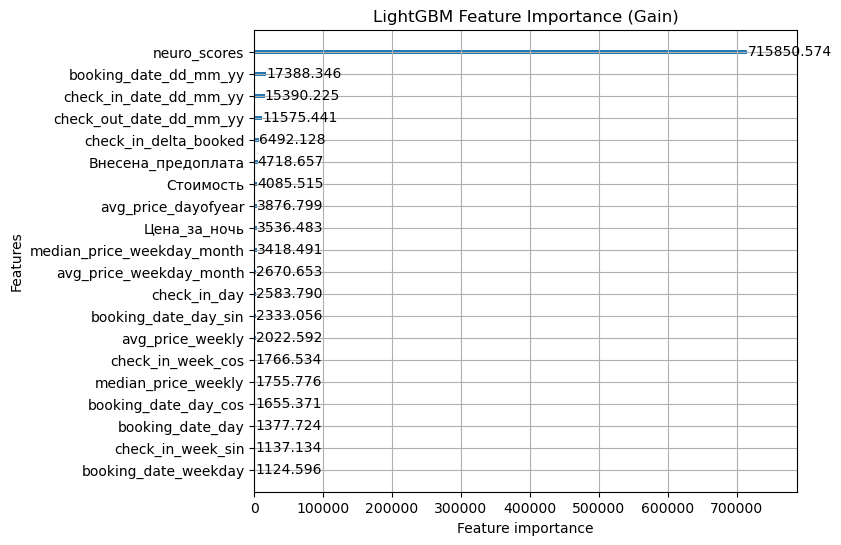

------------------------------------------


In [72]:
show_importances(lgbm_destroyX)

In [75]:
%time

df_encriched_lgbm = prepare_for_lgbm(df_encriched)

X = df_encriched_lgbm.drop(columns=["target"])
# X.loc[:, 'neuro_scores'] = scores_train.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

lgbm_destroyX = LGBMClassifier(**hyper_params4)
lgbm_destroyX.fit(X_train, y_train)

y_pred_proba = lgbm_destroyX.predict_proba(X_test)[:, 1]

# Оценка метрики ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

CPU times: total: 0 ns
Wall time: 0 ns
ROC-AUC: 0.8530


In [79]:
gain_importance = lgbm_destroyX.feature_importances_
feature_names = X_train.columns

df_importance = (
    pd.DataFrame({'Feature': feature_names, 'Gain (Split)': gain_importance})
    .sort_values(by='Gain (Split)', ascending=False)
)
display(df_importance.head(30))

,Feature,Gain (Split)
16,check_in_delta_booked,2352
1,Стоимость,1934
2,Внесена предоплата,1354
39,Цена_за_ночь,926
42,avg_price_weekday_month,788
40,avg_price_weekly,747
43,median_price_weekday_month,741
31,booking_date_day_sin,670
41,median_price_weekly,646
44,avg_price_dayofyear,589


### CatBoost v2

In [218]:
X.loc[:, 'neuro_scores'] = scores_train.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [ ]:
X = df_encriched_lgbm.drop(columns=["target"])

# X.loc[:, 'neuro_scores'] = scores_train.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

categorical_features_indices = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

param = {
        'iterations': 300,
        'depth': 8,
        'learning_rate': 0.002,
        'l2_leaf_reg': 2.2,
        'random_seed': 42,
        'cat_features': categorical_features_indices,
        'verbose': -1  # Отключаем вывод
    }

CatBoosterX = CatBoostClassifier(**param)
    
# Обучение модели
CatBoosterX.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=20, verbose=0)

# Получение вероятностей принадлежности к классу 1 на тестовой выборке
y_pred_proba = CatBoosterX.predict_proba(X_test)[:, 1]

In [ ]:
categorical_features_indices = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

param = {
        'iterations': 300,
        'depth': 8,
        'learning_rate': 0.002,
        'l2_leaf_reg': 2.2,
        'random_seed': 42,
        'cat_features': categorical_features_indices,
        'verbose': -1  # Отключаем вывод
    }

CatBoosterX = CatBoostClassifier(**param)
    
# Обучение модели
CatBoosterX.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=20, verbose=0)

# Получение вероятностей принадлежности к классу 1 на тестовой выборке
y_pred_proba = CatBoosterX.predict_proba(X_test)[:, 1]

In [ ]:
# с энрич
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

In [91]:
# без энрич
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

ROC-AUC: 0.8825


In [92]:
%load_ext autoreload
%autoreload 2

scores_test = pd.read_csv('nn_04.csv', header=None)
from feature_generation_funcs import (
    data_baseline_prepare_, price_features_, calendar_features_)
df_test = (
    pd.read_excel("test.xlsx")
    .drop(columns="Unnamed: 0")
    .set_index('№ брони')
)
df_test = data_baseline_prepare_(df_test)
df_test = calendar_features_(df_test)
df_test = sin_cos_coder(df_test)
df_test = price_features_(df_test)
df_test.loc[:, 'neuro_scores'] = scores_test.values
df_test = prepare_for_lgbm(df_test)
y_pred = CatBoosterX.predict_proba(df_test)[:, 1]

y_pred = pd.DataFrame(y_pred)
y_pred.to_csv('baseline13.csv', header=None, index=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
in 12 >>> processing... >>> out 26


100%|██████████| 11218/11218 [00:00<00:00, 239119.09it/s]

in 26 >>> processing... >>> out 34


In [ ]:
categorical_features_indices = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

param = {
        'iterations': 300,
        'depth': 8,
        'learning_rate': 0.002,
        'l2_leaf_reg': 2.2,
        'random_seed': 42,
        'cat_features': categorical_features_indices,
        'verbose': -1  # Отключаем вывод
    }

CatBoosterX = CatBoostClassifier(**param)
    
# Обучение модели
CatBoosterX.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=20, verbose=0)

# Получение вероятностей принадлежности к классу 1 на тестовой выборке
y_pred_proba = CatBoosterX.predict_proba(X_test)[:, 1]

In [95]:
from catboost import EShapCalcType, EFeaturesSelectionAlgorithm, Pool
feature_names = list(X_train.columns)
train_pool = Pool(X_train, y_train, feature_names=feature_names, cat_features = categorical_features_indices)
test_pool = Pool(X_test, y_test, feature_names=feature_names, cat_features = categorical_features_indices)
# feature_names = list(X_train.columns)

In [ ]:
model = CatBoostClassifier(iterations=1000, random_seed=42)
summary = model.select_features(
    train_pool,
    eval_set=test_pool,
    features_for_select=feature_names,
    num_features_to_select=40,
    steps=3,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=False,
    logging_level='Silent',
    plot=True
)

In [103]:
selected_features = summary['selected_features_names']
X_train_RF, X_test_RF = X_train[selected_features], X_test[selected_features]

In [306]:
selected_features_no_neuro

['Стоимость',
 'Внесена предоплата',
 'Способ оплаты',
 'Ночей',
 'Источник',
 'Категория номера',
 'Гостей',
 'Гостиница',
 'booking_date_dd_mm_yy',
 'booking_date_month',
 'check_in_date_year_month',
 'Источник_agg',
 'non_confirmed',
 'booking_date_is_holiday',
 'booking_date_month_sin',
 'booking_date_month_cos',
 'check_in_weekday_cos',
 'is_beneficial_2',
 'tempmax',
 'tempmin',
 'temp',
 'feelslikemax',
 'feelslikemin',
 'humidity',
 'precip',
 'precipcover',
 'snow',
 'snowdepth',
 'windgust',
 'windspeed',
 'winddir',
 'pressure',
 'cloudcover',
 'visibility',
 'solarradiation',
 'uvindex',
 'moonphase',
 'preciptype_1',
 'preciptype_2']

In [246]:
selected_features_no_neuro = selected_features[:-1]

In [247]:
X = df_encriched_lgbm.drop(columns=["target"])

# X.loc[:, 'neuro_scores'] = scores_train.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train_RF, X_test_RF = X_train[selected_features_no_neuro], X_test[selected_features_no_neuro]
categorical_features_indices = X_train_RF.select_dtypes(include=['object', 'category']).columns.tolist()

In [255]:
import gc
gc.collect()

7888

In [264]:
params = {
    'loss_function': 'Logloss',
    'iterations': 250,
    'custom_loss': 'AUC',
    'random_seed': 0,
    'depth': 4,
    'learning_rate': 0.4,
    'random_seed': 42,
    'cat_features': categorical_features_indices,
    "model_shrink_rate": 0.8,
    "model_shrink_mode": 'Decreasing' 
}

CatBoosterXRF = CatBoostClassifier(**params)
    
# Обучение модели
CatBoosterXRF.fit(X_train_RF, y_train, eval_set=(X_test_RF, y_test), early_stopping_rounds=20, verbose=0)

# Получение вероятностей принадлежности к классу 1 на тестовой выборке
y_pred_proba = CatBoosterXRF.predict_proba(X_test_RF)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

ROC-AUC: 0.8100


In [ ]:
# !pip install optuna

# import pandas as pd
from catboost import CatBoostClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import roc_auc_score
import optuna

# Загрузка данных
# data = pd.read_csv('your_data.csv')


# Указание категориальных признаков
# categorical_features_indices = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Определение функции для оптимизации
def objective(trial):
    # Определение пространства гиперпараметров
    param = {
        'loss_function': 'Logloss',
        'iterations': trial.suggest_int('iterations', 20, 300),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1, 4),
        'random_seed': 42,
        'cat_features': categorical_features_indices,
        'verbose': 0  # Отключаем вывод
    }
    
    # Создание и обучение модели CatBoostClassifier
    model = CatBoostClassifier(**param)
    
    # Обучение модели
    model.fit(X_train_RF, y_train, eval_set=(X_test_RF, y_test), early_stopping_rounds=20, verbose=0)
    
    # Получение вероятностей принадлежности к классу 1 на тестовой выборке
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Оценка качества модели с использованием ROC AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    return roc_auc

# Запуск оптимизации
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Вывод лучших параметров
print("Best trial:")
trial = study.best_trial
print(f"  Value (ROC AUC): {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

In [270]:
X = df_ne_baseline_w_calendar_price_lgbm.drop(columns=["target"])

X.loc[:, 'neuro_scores'] = scores_train.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

categorical_features_indices = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

param = {
        'iterations': 300,
        'depth': 8,
        'learning_rate': 0.002,
        'l2_leaf_reg': 2.2,
        'random_seed': 42,
        'cat_features': categorical_features_indices,
        'verbose': -1  # Отключаем вывод
    }

CatBoosterX_ = CatBoostClassifier(**param)
    
# Обучение модели
CatBoosterX_.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=20, verbose=0)

# Получение вероятностей принадлежности к классу 1 на тестовой выборке
y_pred_proba = CatBoosterX_.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

ROC-AUC: 0.8821


In [ ]:
# Определение функции для оптимизации
def objective(trial):
    # Определение пространства гиперпараметров
    param = {
        'loss_function': 'Logloss',
        'iterations': trial.suggest_int('iterations', 20, 300),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1, 4),
        'random_seed': 42,
        'cat_features': categorical_features_indices,
        'verbose': 0  # Отключаем вывод
    }
    
    # Создание и обучение модели CatBoostClassifier
    model = CatBoostClassifier(**param)
    
    # Обучение модели
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=20, verbose=0)
    
    # Получение вероятностей принадлежности к классу 1 на тестовой выборке
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Оценка качества модели с использованием ROC AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    return roc_auc

# Запуск оптимизации
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Вывод лучших параметров
print("Best trial:")
trial = study.best_trial
print(f"  Value (ROC AUC): {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

In [275]:
import gc
gc.collect()

6884

In [278]:
X = df_ne_baseline_w_calendar_price_lgbm.drop(columns=["target"])

X.loc[:, 'neuro_scores'] = scores_train.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

categorical_features_indices = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

param_opt = study.best_params
param_opt['cat_features'] = categorical_features_indices


CatBoosterOPT = CatBoostClassifier(**param_opt)
    
# Обучение модели
CatBoosterOPT.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=20, verbose=0)

# Получение вероятностей принадлежности к классу 1 на тестовой выборке
y_pred_proba = CatBoosterOPT.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

ROC-AUC: 0.8852


In [281]:
%load_ext autoreload
%autoreload 2

scores_test = pd.read_csv('nn_04.csv', header=None)
from feature_generation_funcs import (
    data_baseline_prepare_, price_features_, calendar_features_)
df_test = (
    pd.read_excel("test.xlsx")
    .drop(columns="Unnamed: 0")
    .set_index('№ брони')
)
df_test = data_baseline_prepare_(df_test)
df_test = calendar_features_(df_test)
df_test = sin_cos_coder(df_test)
df_test = price_features_(df_test)
df_test.loc[:, 'neuro_scores'] = scores_test.values
df_test = prepare_for_lgbm(df_test)
y_pred = CatBoosterOPT.predict_proba(df_test)[:, 1]

y_pred = pd.DataFrame(y_pred)
y_pred.to_csv('baseline14.csv', header=None, index=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
in 12 >>> processing... >>> out 26


100%|██████████| 11218/11218 [00:00<00:00, 184351.65it/s]


in 26 >>> processing... >>> out 34


In [282]:
X = df_ne_baseline_w_calendar_price_lgbm.drop(columns=["target"])

# X.loc[:, 'neuro_scores'] = scores_train.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

categorical_features_indices = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

param_opt = study.best_params
param_opt['cat_features'] = categorical_features_indices


CatBoosterOPT = CatBoostClassifier(**param_opt)
    
# Обучение модели
CatBoosterOPT.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=20, verbose=0)

# Получение вероятностей принадлежности к классу 1 на тестовой выборке
y_pred_proba = CatBoosterOPT.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

ROC-AUC: 0.8669


In [284]:
%load_ext autoreload
%autoreload 2

# scores_test = pd.read_csv('nn_04.csv', header=None)
from feature_generation_funcs import (
    data_baseline_prepare_, price_features_, calendar_features_)
df_test = (
    pd.read_excel("test.xlsx")
    .drop(columns="Unnamed: 0")
    .set_index('№ брони')
)
df_test = data_baseline_prepare_(df_test)
df_test = calendar_features_(df_test)
df_test = sin_cos_coder(df_test)
df_test = price_features_(df_test)
# df_test.loc[:, 'neuro_scores'] = scores_test.values
df_test = prepare_for_lgbm(df_test)
y_pred = CatBoosterOPT.predict_proba(df_test)[:, 1]

y_pred = pd.DataFrame(y_pred)
y_pred.to_csv('baseline15.csv', header=None, index=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
in 12 >>> processing... >>> out 26


100%|██████████| 11218/11218 [00:00<00:00, 212229.49it/s]

in 26 >>> processing... >>> out 34


In [286]:
y_pred_train = CatBoosterOPT.predict_proba(X)[:, 1]
y_pred_train = pd.DataFrame(y_pred_train)
y_pred_train.to_csv('baseline15_train.csv', header=None, index=False)

### Doubled neuro features

In [291]:
scores_train2 = pd.read_csv('baseline15_train.csv', header=None)
scores_test2 = pd.read_csv('baseline15.csv', header=None)

In [297]:
X = df_ne_baseline_w_calendar_price_lgbm.drop(columns=["target"])

X.loc[:, 'neuro_scores'] = scores_train.values
X.loc[:, 'boost_scores'] = scores_train2.values


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

categorical_features_indices = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

param_opt = study.best_params
param_opt['cat_features'] = categorical_features_indices

CatBoosterOPT_MONSTER = CatBoostClassifier(**param_opt)
    
# Обучение модели
CatBoosterOPT_MONSTER.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=20, verbose=0)

# Получение вероятностей принадлежности к классу 1 на тестовой выборке
y_pred_proba = CatBoosterOPT_MONSTER.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

ROC-AUC: 0.8839


In [304]:
%load_ext autoreload
%autoreload 2

# scores_test = pd.read_csv('nn_04.csv', header=None)
from feature_generation_funcs import (
    data_baseline_prepare_, price_features_, calendar_features_)
df_test = (
    pd.read_excel("test.xlsx")
    .drop(columns="Unnamed: 0")
    .set_index('№ брони')
)
df_test = data_baseline_prepare_(df_test)
df_test = calendar_features_(df_test)
df_test = sin_cos_coder(df_test)
df_test = price_features_(df_test)
df_test.loc[:, 'neuro_scores'] = scores_test.values
df_test.loc[:, 'boost_scores'] = scores_test2.values
df_test = prepare_for_lgbm(df_test)
y_pred = CatBoosterOPT_MONSTER.predict_proba(df_test)[:, 1]

y_pred = pd.DataFrame(y_pred)
y_pred.to_csv('baseline16_fixed.csv', header=None, index=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
in 12 >>> processing... >>> out 26


100%|██████████| 11218/11218 [00:00<00:00, 229392.93it/s]

in 26 >>> processing... >>> out 34


----

In [301]:
X = df_ne_baseline_w_calendar_price_lgbm.drop(columns=["target"])

X.loc[:, 'neuro_scores'] = scores_train.values
X.loc[:, 'boost_scores'] = scores_train2.values


# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.4, random_state=42, stratify=y
# )

categorical_features_indices = X.select_dtypes(include=['object', 'category']).columns.tolist()

param_opt = study.best_params
param_opt['cat_features'] = categorical_features_indices

CatBoosterOPT_MONSTER_FULLHD = CatBoostClassifier(**param_opt)
    
# Обучение модели
CatBoosterOPT_MONSTER_FULLHD.fit(X, y, early_stopping_rounds=20, verbose=0)

# Получение вероятностей принадлежности к классу 1 на тестовой выборке
# y_pred_proba = CatBoosterOPT_MONSTER_FULLHD.predict_proba(X_test)[:, 1]

# roc_auc = roc_auc_score(y_test, y_pred_proba)
# print(f"ROC-AUC: {roc_auc:.4f}")

In [302]:
%load_ext autoreload
%autoreload 2

# scores_test = pd.read_csv('nn_04.csv', header=None)
from feature_generation_funcs import (
    data_baseline_prepare_, price_features_, calendar_features_)
df_test = (
    pd.read_excel("test.xlsx")
    .drop(columns="Unnamed: 0")
    .set_index('№ брони')
)
df_test = data_baseline_prepare_(df_test)
df_test = calendar_features_(df_test)
df_test = sin_cos_coder(df_test)
df_test = price_features_(df_test)
df_test.loc[:, 'neuro_scores'] = scores_test.values
df_test.loc[:, 'boost_scores'] = scores_test2.values
df_test = prepare_for_lgbm(df_test)
y_pred = CatBoosterOPT_MONSTER_FULLHD.predict_proba(df_test)[:, 1]

y_pred = pd.DataFrame(y_pred)
y_pred.to_csv('baseline17.csv', header=None, index=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
in 12 >>> processing... >>> out 26


100%|██████████| 11218/11218 [00:00<00:00, 212223.75it/s]

in 26 >>> processing... >>> out 34


### Full catboost no neuro features

In [319]:
X = df_ne_baseline_w_calendar_price_lgbm.drop(columns=["target"])

# X.loc[:, 'neuro_scores'] = scores_train.values

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.3, random_state=42, stratify=y
# )

categorical_features_indices = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

param_opt = study.best_params
param_opt['cat_features'] = categorical_features_indices
param_opt['scale_pos_weight'] = 0.2


CatBoosterOPT_FULLHD = CatBoostClassifier(**param_opt)
    
# Обучение модели
CatBoosterOPT_FULLHD.fit(X, y, early_stopping_rounds=20, verbose=0)

# Получение вероятностей принадлежности к классу 1 на тестовой выборке
y_pred_proba = CatBoosterOPT_FULLHD.predict_proba(X_train)[:, 1]

roc_auc = roc_auc_score(y_train, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

ROC-AUC: 0.8940


In [317]:
y_pred_proba = CatBoosterOPT_FULLHD.predict_proba(X_train)[:, 1]

In [305]:
%load_ext autoreload
%autoreload 2

# scores_test = pd.read_csv('nn_04.csv', header=None)
from feature_generation_funcs import (
    data_baseline_prepare_, price_features_, calendar_features_)
df_test = (
    pd.read_excel("test.xlsx")
    .drop(columns="Unnamed: 0")
    .set_index('№ брони')
)
df_test = data_baseline_prepare_(df_test)
df_test = calendar_features_(df_test)
df_test = sin_cos_coder(df_test)
df_test = price_features_(df_test)
# df_test.loc[:, 'neuro_scores'] = scores_test.values
df_test = prepare_for_lgbm(df_test)
y_pred = CatBoosterOPT_FULLHD.predict_proba(df_test)[:, 1]

y_pred = pd.DataFrame(y_pred)
y_pred.to_csv('baseline18.csv', header=None, index=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
in 12 >>> processing... >>> out 26


100%|██████████| 11218/11218 [00:00<00:00, 208299.37it/s]

in 26 >>> processing... >>> out 34


In [307]:
from catboost import datasets, Pool
from catboost.utils import get_roc_curve, eval_metric
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [320]:
X = df_ne_baseline_w_calendar_price_lgbm.drop(columns=["target"])

# X.loc[:, 'neuro_scores'] = scores_train.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

categorical_features_indices = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

param_opt = study.best_params
param_opt['cat_features'] = categorical_features_indices
param_opt['scale_pos_weight'] = 0.2


CatBooster22 = CatBoostClassifier(**param_opt)
    
# Обучение модели
CatBooster22.fit(X, y, early_stopping_rounds=40, verbose=0)

# Получение вероятностей принадлежности к классу 1 на тестовой выборке
y_pred_proba = CatBooster22.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

ROC-AUC: 0.9052


In [321]:
%load_ext autoreload
%autoreload 2

scores_test = pd.read_csv('nn_04.csv', header=None)
from feature_generation_funcs import (
    data_baseline_prepare_, price_features_, calendar_features_)
df_test = (
    pd.read_excel("test.xlsx")
    .drop(columns="Unnamed: 0")
    .set_index('№ брони')
)
df_test = data_baseline_prepare_(df_test)
df_test = calendar_features_(df_test)
df_test = sin_cos_coder(df_test)
df_test = price_features_(df_test)
df_test.loc[:, 'neuro_scores'] = scores_test.values
df_test = prepare_for_lgbm(df_test)
y_pred = CatBooster22.predict_proba(df_test)[:, 1]

y_pred = pd.DataFrame(y_pred)
y_pred.to_csv('baseline19.csv', header=None, index=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
in 12 >>> processing... >>> out 26


100%|██████████| 11218/11218 [00:00<00:00, 197219.75it/s]

in 26 >>> processing... >>> out 34


In [329]:
weight_feature = np.ones(len(X_train.columns.tolist()))

In [331]:
weight_feature[-1] = 0.1

In [332]:
weight_feature

array([1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 0.1])

In [322]:
X_train.columns.tolist()

['Номеров',
 'Стоимость',
 'Внесена предоплата',
 'Способ оплаты',
 'Ночей',
 'Источник',
 'Категория номера',
 'Гостей',
 'Гостиница',
 'booking_date_dd_mm_yy',
 'booking_date_day',
 'booking_date_month',
 'booking_date_month_name',
 'booking_date_year',
 'booking_date_year_month',
 'check_in_date_dd_mm_yy',
 'check_in_delta_booked',
 'check_in_date_year_month',
 'check_out_date_dd_mm_yy',
 'check_out_date_year_month',
 'Источник_agg',
 'Категория_номера_agg',
 'non_confirmed',
 'check_in_is_holiday',
 'booking_date_is_holiday',
 'check_out_is_holiday',
 'check_in_weekday',
 'booking_date_weekday',
 'check_out_weekday',
 'check_in_week',
 'check_in_day',
 'booking_date_day_sin',
 'booking_date_day_cos',
 'booking_date_month_sin',
 'booking_date_month_cos',
 'check_in_weekday_sin',
 'check_in_weekday_cos',
 'check_in_week_sin',
 'check_in_week_cos',
 'Цена_за_ночь',
 'avg_price_weekly',
 'median_price_weekly',
 'avg_price_weekday_month',
 'median_price_weekday_month',
 'avg_price_dayof

In [333]:
X = df_ne_baseline_w_calendar_price_lgbm.drop(columns=["target"])

X.loc[:, 'neuro_scores'] = scores_train.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

categorical_features_indices = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

param_opt = study.best_params
param_opt['cat_features'] = categorical_features_indices
param_opt['scale_pos_weight'] = 0.2
param_opt['feature_weights'] = weight_feature

CatBooster23 = CatBoostClassifier(**param_opt)
    
# Обучение модели
CatBooster23.fit(X, y, early_stopping_rounds=40, verbose=0)

# Получение вероятностей принадлежности к классу 1 на тестовой выборке
y_pred_proba = CatBooster23.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

ROC-AUC: 0.9053


In [352]:
df_encriched_1 = df_encriched_1.drop(columns = ['preciptype_1', 'preciptype_2'])

In [360]:
df_encriched_moonphase

,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Заезд,Ночей,Выезд,Источник,Категория номера,Гостей,Гостиница,target,booking_date_dd_mm_yy,booking_date_day,booking_date_month,booking_date_month_name,booking_date_year,booking_date_year_month,check_in_date_dd_mm_yy,check_in_delta_booked,check_in_date_year_month,check_out_date_dd_mm_yy,check_out_date_year_month,Источник_agg,Категория_номера_agg,non_confirmed,check_in_is_holiday,booking_date_is_holiday,check_out_is_holiday,check_in_weekday,booking_date_weekday,check_out_weekday,check_in_week,check_in_day,booking_date_day_sin,booking_date_day_cos,booking_date_month_sin,booking_date_month_cos,check_in_weekday_sin,check_in_weekday_cos,check_in_week_sin,check_in_week_cos,Цена_за_ночь,avg_price_weekly,median_price_weekly,avg_price_weekday_month,median_price_weekday_month,avg_price_dayofyear,is_beneficial,is_beneficial_2,is_beneficial_3,moonphase
0,1,25700.0,0,Внешняя система оплаты,2023-04-20 20:37:30,2023-04-28 15:00:00,3,2023-05-01 12:00:00,Яндекс.Путешествия,Номер «Стандарт»,2,1,1,20-04-23,20,4,Apr,2023,202304,28-04-23,7,202304,01-05-23,202305,Яндекс.Путешествия,Номер «Стандарт»,0,0,0,1,4,3,0,17,118,-0.790776,-0.612106,8.660254e-01,-5.000000e-01,-8.660254e-01,-0.5,0.885456,-0.464723,8566.666667,7659.259259,8000.0,10037.881944,10125.000000,8590.476190,1,1,0,0.25
1,1,24800.0,12400,Отложенная электронная оплата: Банк Россия (ба...,2022-06-18 14:17:02,2022-07-11 15:00:00,2,2022-07-13 12:00:00,Официальный сайт,Номер «Стандарт»,2,1,0,18-06-22,18,6,Jun,2022,202206,11-07-22,23,202207,13-07-22,202207,Официальный сайт,Номер «Стандарт»,1,0,1,0,0,5,2,28,192,-0.485302,-0.874347,1.224647e-16,-1.000000e+00,0.000000e+00,1.0,-0.239316,-0.970942,12400.000000,9900.985714,10400.0,9578.764881,9816.666667,10202.058824,0,0,0,0.42
2,1,25800.0,12900,Банк. карта: Банк Россия (банк. карта),2022-11-14 22:59:30,2022-12-04 15:00:00,2,2022-12-06 12:00:00,Официальный сайт,Номер «Студия»,2,4,0,14-11-22,14,11,Nov,2022,202211,04-12-22,19,202212,06-12-22,202212,Официальный сайт,Номер «Студия»,0,1,0,0,6,0,1,48,338,0.299363,-0.954139,-5.000000e-01,8.660254e-01,-2.449294e-16,1.0,-0.464723,0.885456,12900.000000,14145.833333,14300.0,16660.617647,15016.666667,12387.500000,0,1,1,0.37
3,1,10500.0,0,Внешняя система оплаты (С предоплатой),2023-09-08 15:55:53,2023-09-18 15:00:00,1,2023-09-19 12:00:00,Bronevik.com(new),Номер «Стандарт»,1,3,0,08-09-23,8,9,Sep,2023,202309,18-09-23,9,202309,19-09-23,202309,Bronevik.com(new),Номер «Стандарт»,0,0,0,0,0,4,1,38,261,0.998717,-0.050649,-1.000000e+00,-1.836970e-16,0.000000e+00,1.0,-0.992709,-0.120537,10500.000000,10435.292621,10117.5,9223.384735,8820.000000,9351.279762,0,0,0,0.12
4,1,28690.0,28690,Система быстрых платежей: Эквайринг ComfortBoo...,2023-05-20 19:54:13,2023-05-29 15:00:00,2,2023-05-31 12:00:00,Официальный сайт,Номер «Люкс»,4,1,0,20-05-23,20,5,May,2023,202305,29-05-23,8,202305,31-05-23,202305,Официальный сайт,Номер «Люкс»,0,0,1,0,0,5,2,22,149,-0.790776,-0.612106,5.000000e-01,-8.660254e-01,0.000000e+00,1.0,0.464723,-0.885456,14345.000000,14148.750000,13322.5,14052.500000,14372.500000,12239.500000,0,0,0,0.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26169,1,18240.0,9120,Банк. карта: Банк Россия (банк. карта),2023-01-07 17:45:18,2023-03-10 15:00:00,2,2023-03-12 12:00:00,Официальный сайт,Номер «Стандарт»,2,2,0,07-01-23,7,1,Jan,2023,202301,10-03-23,61,202303,12-03-23,202303,Официальный сайт,Номер «Стандарт»,0,0,1,1,4,5,6,10,69,0.988468,0.151428,5.000000e-01,8.660254e-01,-8.660254e-01,-0.5,0.935016,0.354605,9120.000000,8890.982906,8280.0,9774.458333,9168.333333,7991.666667,0,1,0,0.60
26170,1,69600.0,23200,Банк. карта: Банк Россия (банк. карта),2023-06-20 17:54:17,2023-06-25 15:00:00,3,2023-06-28 12:00:00,Официальный сайт,Номер «Студия»,3,4,0,20-06-23,20,6,Jun,2023,202306,25-06-23,4,202306,28

In [365]:
df_encriched_moonphase["Способ оплаты_flg"] = (
    df_encriched_moonphase["Способ оплаты"]
    .str.contains("Отложенная электронная оплата")
    .astype("int")
)

In [404]:
X = prepare_for_lgbm(df_encriched_moonphase).drop(columns=["target"])

# X.loc[:, 'neuro_scores'] = scores_train.values

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.3, random_state=42, stratify=y
# )

categorical_features_indices = X.select_dtypes(include=['object', 'category']).columns.tolist()

param_opt = study.best_params
param_opt['cat_features'] = categorical_features_indices

# param_opt['scale_pos_weight'] = 0.2


CatBoosterTOTHEMOOON = CatBoostClassifier(**param_opt)
    
# Обучение модели
CatBoosterTOTHEMOOON.fit(X, y, early_stopping_rounds=40, verbose=0)

# Получение вероятностей принадлежности к классу 1 на тестовой выборке
y_pred_proba = CatBoosterTOTHEMOOON.predict_proba(X)[:, 1]

roc_auc = roc_auc_score(y, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

ROC-AUC: 0.9119


In [397]:
%load_ext autoreload
%autoreload 2

# scores_test = pd.read_csv('nn_04.csv', header=None)
from feature_generation_funcs import (
    data_baseline_prepare_, price_features_, calendar_features_)
df_test = (
    pd.read_excel("test.xlsx")
    .drop(columns="Unnamed: 0")
    .set_index('№ брони')
)
df_test = data_baseline_prepare_(df_test)
df_test = calendar_features_(df_test)
df_test = sin_cos_coder(df_test)
df_test = price_features_(df_test)
df_test.loc[:, 'neuro_scores'] = scores_test.values
df_test.loc[:, 'boost_scores'] = scores_test2.values
df_test = prepare_for_lgbm(df_test)
y_pred = CatBoosterOPT_MONSTER_FULLHD.predict_proba(df_test)[:, 1]

y_pred = pd.DataFrame(y_pred)
y_pred.to_csv('baseline17.csv', header=None, index=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
in 12 >>> processing... >>> out 26


100%|██████████| 11218/11218 [00:00<00:00, 212228.53it/s]

in 26 >>> processing... >>> out 34


In [406]:
%load_ext autoreload
%autoreload 2

scores_test = pd.read_csv('nn_04.csv', header=None)
from feature_generation_funcs import (
    data_baseline_prepare_, price_features_, calendar_features_)
df_test = (
    pd.read_excel("test.xlsx")
    .drop(columns="Unnamed: 0")
    .set_index('№ брони')
)
df_test = data_baseline_prepare_(df_test)
df_test = calendar_features_(df_test)
df_test = sin_cos_coder(df_test)
df_test = price_features_(df_test)
# df_test.loc[:, 'neuro_scores'] = scores_test.values

df_test['Заезд_dt'] =  df_test['Заезд'].dt.date.astype('string')

df_test = df_test.merge(
    right=df_weather_sub2,
    how="left",
    left_on="Заезд_dt",
    right_on="datetime",
)
df_test = df_test.drop(columns=['Заезд_dt', 'datetime'])

df_test['Способ оплаты_flg'] = df_test['Способ оплаты'].str.contains('Отложенная электронная оплата').astype('int')
df_test = prepare_for_lgbm(df_test)
y_pred = CatBoosterTOTHEMOOON.predict_proba(df_test)[:, 1]

y_pred = pd.DataFrame(y_pred)
y_pred.to_csv('baseline20.csv', header=None, index=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
in 12 >>> processing... >>> out 26


100%|██████████| 11218/11218 [00:00<00:00, 224795.41it/s]

in 26 >>> processing... >>> out 34


---